# Social Graphs: Explainer Notebook

In [1]:
import pandas as pd
import json
import urllib
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import PIL as PIL
import powerlaw

from fa2 import ForceAtlas2
import plotly.express as px
sns.set()

from statistics import mean
from collections import Counter

from fa2 import ForceAtlas2
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize 
from nltk import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


[nltk_data] Downloading package wordnet to /Users/philip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/philip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/philip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Motivation

### What is your dataset?
In this notebook, we will explore a dataset composed from the *Avatar: The Last Airbender* (ATLA) [fandom wiki](https://avatar.fandom.com/wiki/Avatar_Wiki).
Specifically, the dataset consists of the character pages for all ATLA characters. This includes characters from
the sequel series *The Legend of Korra*. The fandom wiki lists a total of 625 pages related to characters.
The wiki also contains episode transcripts for both series.

We will have to manually extract both character pages and the episode transcripts in a meaningful way. The most difficult is the episode transcripts, which require quite a bit of data processing to turn it into a data set consisting of dialogue attributed to characters.

The character pages have a total size of 6.9 MB. The character dialogue is 1.8 MB. 

For reference, each series consists of invidual seasons denoted *books*. In this notebook we will use *book* and *season* interchangeably unless stated otherwise.

### Why did you choose this particular dataset?
The ATLA dataset is well suited for analysis, both due to the appropriate number of character pages and their individual sizes.
The ATLA universe is also neatly categorized. Each character resides from one of four nations and is capable of *bending* (i.e. manipulating)
one of the four basic elements (water, air, fire and earth).
It was also important that episode transcripts were readily available, since we knew that we wanted
to employ NLP. The fact that there are two series with several seasons also makes temporal analysis ideal.
Finally, ATLA is a critically acclaimed animation series with a large, passionate fanbase. The authors of this notebook are also fans of the series.
We wish to appease the fans by providing additional ATLA content for consumption.

### What was your goal for the end user's experience?

In this notebook, we wish to further explore the universe of *Avatar: The Last Airbender*. We will be looking into the effect of nationality. Is the Fire Nation really as evil as we think? What terms does the series associate with each nation? We will also explore the sentiment of characters, seasons and episodes using natural language processing. We will be determine the brighest and most negative characters. We will also determine the differences between the two series in regards to mood. 

## Basic stats

In this section, we will firstly create the dataset through various API calls to the fandom wiki. Afterwards, we can create the character network.
Finally, descriptive statistics and visualizations concerning the dataset and network will take place.

### Extracting characters from Avatar: The Last Airbender fandom wiki

Here the all character names and nationalities from the wiki are extracted. The wiki contains several category pages that we can use for this purpose. Since we are interested in finding the nationality of each character, we will use the following category pages:
- Water Tribe characters
- Earth Kingdom characters
- Fire Nation characters
- United Republic characters

The first four category pages are the archetypical countries in ATLA. The last country, the *United Republic*, is only introduced later on in *The Legend of Korra* and can be seen as an amalgation of the previous four. Using the above pages, the nationality of each character can be found without additional scraping. However, there are also characters that are not associated with a country. In order to find these characters, we will also use the top-level character category page containing **all** character in the universe.

We do a small amount of data-cleaning regarding the characters included. A few characters are exclusive to non-canon video games and pilot episodes. We therefore exclude these.

In [2]:
data = pd.DataFrame({'name': [], 'nationality': []})

In [3]:
url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=500&prop=revisions&rvprop=content&rvslots=*'
base_url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:'
page_titles = ['Water_Tribe_characters', 'Earth_Kingdom_characters', 'Fire_Nation_characters', 'Air_Nation_characters', 'United_Republic_characters', 'Characters']
character_nationalities = ['Water Tribe', 'Earth Kingdom', 'Fire Nation', 'Air Nation', 'United Republic', None]
end_url = '&cmlimit=500&prop=revisions&rvprop=content&rvslots=*&format=json'

for page_title, character_nationality in zip(page_titles, character_nationalities):
    url = base_url + page_title + end_url
    response = urllib.request.urlopen(url)
    page = json.load(response)
    category_members = page['query']['categorymembers']
    
    # Extract page title and character nationality.
    character_names = [item['title'] for item in category_members] 
    
    # Some pages may be longer than 500 members.
    if 'continue' in page.keys():
        cmcont = page['continue']['cmcontinue']
        url = base_url + page_title + end_url + '&cmcontinue=' + cmcont
        response = urllib.request.urlopen(url)
        page = json.load(response)
        category_members = page['query']['categorymembers']
        character_names += [item['title'] for item in category_members] 
        
    
    # Some Category:* items will be included. These are not important, so we can discard them.
    # We also don't want any characters from games or pilot episodes.
    filtered = filter(lambda title: 'Category:' not in title and 'pilot' not in title and 'games' not in title, character_names)
    character_names = list(filtered)

    # Might as well get nationality here.
    name_and_type = {'name': character_names, 'nationality': [character_nationality for _ in character_names]}

    # Merge with existing data frame.
    df = pd.DataFrame.from_dict(name_and_type)
    data = data.append(df)

    
# A few characters can get included multiple times.
data = data.drop_duplicates(subset='name')

# Some entries might have duplicate indices
data = data.reset_index(drop=True)

data.head(10)


,name,nationality
0,Amak,Water Tribe
1,Amon,Water Tribe
2,Arnook,Water Tribe
3,Ashuna,Water Tribe
4,Atuat,Water Tribe
5,Bato,Water Tribe
6,Desna and Eska,Water Tribe
7,Due,Water Tribe
8,Gilak,Water Tribe
9,Hahn,Water Tribe


In [4]:
data.shape

(572, 2)

As seen above, we managed to extract $572$ characters from the category pages. This also means that our network will be close to the same size.

### Downloading character pages

With all character names collected, we can begin extracting individual character pages. The character pages will be used to link character nodes in the network, as done previously in the course. The will also be used to extract additional attributes. The contributors of the wiki have almost completely eliminated the need for disambiguation pages and redirects, making the whole process very simple.

In [5]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'

if not os.path.exists('characters/'):
    os.makedirs('characters/')

for character_name in data['name'].to_numpy():
    # Create URL
    original_name = character_name
    page_title = character_name.replace(' ', '_')
    
    url = base_url + urllib.parse.quote_plus(page_title) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']
    
    # Save to file
    with open('characters/' + original_name.replace('/', '-') + '.txt', 'w') as file:
        file.write(page_content)

In [6]:
data.to_csv('avatar_data.csv')

In [7]:
data = pd.read_csv('avatar_data.csv')

We'll also need to download the pages as plain text for NLP later on. This is done by adding `&prop=extract&explaintext` to the API call.

In [8]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=extracts&explaintext&format=json'

if not os.path.exists('characters_plain_text/'):
    os.makedirs('characters_plain_text/')

for character_name in data['name'].to_numpy():
    # Create URL
    original_name = character_name
    page_title = character_name.replace(' ', '_')
    
    url = base_url + urllib.parse.quote_plus(page_title) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['extract']
    
    # Save to file
    with open('characters_plain_text/' + original_name.replace('/', '-') + '.txt', 'w') as file:
        file.write(page_content)

### Extracting links and creating the network

All data collection required for creating the network is now done. We will now traverse each character page and find hyperlinks to other character pages. This will allow us to create the social network for the ATLA universe. Along the way, character attributes will also be extracted.

It's easiest to first create all nodes in our graph and add all the according attributes. The links will be created after this process.
Each character node posseses the following attributes:
- Nationality
- Gender
- Bending style


This code is used for extracting the bending style of a character. We again use the neatly organized category pages from the wiki. Not all characters are capable of bending - those are labelled as `non-bender`s.

In [9]:
url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=1000&prop=revisions&rvprop=content&rvslots=*'
base_url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:'
end_url = '&cmlimit=500&prop=revisions&rvprop=content&rvslots=*&format=json'


def category_to_list(page_title):
    url = base_url + page_title + end_url
    response = urllib.request.urlopen(url)
    page = json.load(response)
    category_members = page['query']['categorymembers']
    
    # Extract page title and character nationality.
    character_names = [item['title'] for item in category_members] 
    
    # Some Category:* items will be included. These are not important, so we can discard them.
    # We also don't want any characters from games or pilot episodes.
    filtered = filter(lambda title: 'Category:' not in title and 'pilot' not in title and 'games' not in title, character_names)
    character_names = list(filtered)
    return character_names

water_benders = category_to_list('Waterbenders')
air_benders = category_to_list('Airbenders')
fire_benders = category_to_list('Firebenders')
earth_benders = category_to_list('Earthbenders')

def bending_art(name):
    if name in water_benders:
        return 'Waterbender'

    if name in earth_benders:
        return 'Earthbender'

    if name in air_benders:
        return 'Airbender'
    
    if name in fire_benders:
        return 'Firebender'
    
    return 'Non-bender'
    

The following code cell firstly creates all character nodes and inserts attributes. The `gender` attribute is the only attribute that requires RegEx for extraction. 

Gender is typically represented like so:
```
| gender = Male
```
making it easy to extract via a RegEx pattern: `\|[\s]*gender[\s]*=[\s]*(\w+)\n`. The pattern takes into account that there may be a varying amount of whitespace between keywords.

In [10]:
G = nx.DiGraph()
gender_pat = r'\|[\s]*gender[\s]*=[\s]*(\w+)\n'
for name, nationality in data[['name', 'nationality']].to_numpy():
    with open('characters/' + name.replace('/', '-') + '.txt', 'r') as file:
        gender = None
        
        page_content = file.read()

        gender_match = re.findall(gender_pat, page_content)
        if gender_match:
            gender = gender_match[0]
        
        bending_style = bending_art(name)
        G.add_node(name, nationality=nationality, gender=gender, bending_art=bending_style)

Now we'll extract the hyperlinks from the character pages and create the links in the network.

The Avatar wiki only uses `[[...]]` links, which makes link extraction significantly easier. This allows us to get by with a single RegEx pattern: 
`\[\[(.*?)(?:#.*?)?(?:\|.*?)?\]\]`. 

The pattern takes a couple of cases into account. Some hyperlinks are of the form `[[<character_name>#<section>]]` and `[[<character_name> | <alias>]]`. In all cases, we are only interested in `<character_name>`. Most hyperlinks are of the most basic form `[[<character_name>]]`.

In [11]:
# Patterns for detecting links
pat1 = r'\[\[(.*?)(?:#.*?)?(?:\|.*?)?\]\]'

for name in data['name'].to_numpy():
    
    # Open the appropriate text file containing character wiki page previously saved
    with open('characters/' + name.replace('/', '-') + '.txt', 'r') as file:
        page_content = file.read()

        # Convert to set to eliminate duplicates
        page_names = set(re.findall(pat1, page_content))

        for page_name in page_names:
            filtered_name = page_name.replace('+', '\+').replace('(', '\(').replace(')', '\)')
            
            # No self referencing either!
            if data['name'].str.fullmatch(filtered_name).any() and filtered_name != name:
                G.add_edge(name, page_name)

With all links created, let us inspect the final graph briefly.

In [12]:
print('Number of nodes:', G.number_of_nodes())
print('Number of links:', G.number_of_edges())

Number of nodes: 572
Number of links: 6274


We find the network to contain $572$ nodes and $6274$ links. The number of nodes is exactly as expected, as this was the number of character pages found. We find the number of links to be relatively large. It appears that characters in the ATLA universe are, on average, well connected.

Let us now create the GCC. Here we hope that the GCC is not significantly smaller, as that could cause issues. We don't want a network containing very few nodes.

In [13]:
component_list = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
GCC = G.subgraph(component_list[0]).copy()

And let us inspect it as before:

In [14]:
print('Number of nodes:', GCC.number_of_nodes())
print('Number of links:', GCC.number_of_edges())

Number of nodes: 571
Number of links: 6274


We find this to be a success. The GCC only contains 1 node less than the original network. This is perhaps surprising in itself. It indicates that nearly *all* characters are connected and part of a single component.

### Extracting character dialogue from episode transcripts


Since we wish to perform NLP, we will need dialogue associated with each chararcter. The fandom wiki contains transcripts for each episode of both series, which we will use for this purpose. This will require some fiddling, but is overall not particularly difficult.

Our first job is finding the name, book and episode number of each episode. The wiki contains a page for each season of a series. These pages include all episodes of their corresponding season (book) and associated data.

The first series, *Avatar: The Last Airbender*, contains in total 3 books:
- Book One: Water
- Book Two: Earth
- Book Three: Fire

The second series, *The Legend of Korra*, contains in total 4 books:
- Book One: Air
- Book Two: Spirits
- Book Three: Change
- Book Four: Balance

For example, here is an small excerpt from the page regarding the first season of ATLA:

```
| {{Episode box
| series   = 1
| number   = 101
| name     = The Boy in the Iceberg
| image    = Aang in the iceberg.png
| airdate  = February 21, 2005
| writer   = [[Michael Dante DiMartino]], [[Bryan Konietzko]]
| director = [[Dave Filoni]]
| summary  = [[Sokka]] and [[Katara]], two teenage siblings living in the South Pole, discover [[Aang]] and his pet [[flying bison]], [[Appa]], trapped in an iceberg. After Katara frees him, she discovers that he is an [[Airbending|airbender]] and the siblings take him to their home village in the [[Southern Water Tribe]]. Meanwhile, his unfreezing attracts the attention of the Fire Nation's [[Zuko]] intent on capturing him.}}
```

The above shows the `Episode box` for the first episode, *The Boy in the Iceberg*. The information we are interested in here is `series` and `name`. `number` is not useful, since we can easily deduce this later on.
We use a simple RegEx pattern to extract the above.

In [15]:
episode_info_df = pd.DataFrame({'name': [], 'book': [], 'book_number': [], 'episode_number': [], 'series': []})

In [16]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'
page_names = ['Book_One:_Water', 'Book_Two:_Earth', 'Book_Three:_Fire', 'Book_One:_Air', 'Book_Two:_Spirits', 'Book_Three:_Change', 'Book_Four:_Balance']
books = [('Water', '1', '1'), ('Earth', '1', '2'), ('Fire', '1', '3'), ('Air', '2', '1'), ('Spirits', '2', '2'), ('Change', '2', '3'), ('Balance', '2', '4')]

episode_pat = r'\| series   = ([0-9])\s\| number   = [0-9]+\s\| name     = ([\w 0-9 \':,.]+)\s'

episode_number = 1
for page_name, (book_name, _, book_number) in zip(page_names, books):
    # Episode number is found manually

    # Create URL
    url = base_url + urllib.parse.quote_plus(page_name) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']
    
    episode_names = []
    book_names = []
    book_numbers = []
    episode_numbers = []
    series_numbers = []
    
    # Collect episodes for a book
    matches = re.findall(episode_pat, page_content)
    for match in matches:
        series = match[0]
        episode_name = match[1]
        
        episode_names.append(episode_name)
        book_names.append(book_name)
        book_numbers.append(book_number)
        episode_numbers.append(str(episode_number))
        series_numbers.append(series)
        episode_number += 1
    
    # Append the result
    ep_df = pd.DataFrame({'name': episode_names, 'book': book_names, 'book_number': book_numbers, 'episode_number': episode_numbers, 'series': series_numbers})
    episode_info_df = episode_info_df.append(ep_df, ignore_index=True)
    


In [17]:
episode_info_df.to_csv('episode_info.csv')

In [18]:
episode_info_df = pd.read_csv('episode_info.csv')

In [19]:
episode_info_df.head()

,Unnamed: 0,name,book,book_number,episode_number,series
0,0,The Boy in the Iceberg,Water,1,1,1
1,1,The Avatar Returns,Water,1,2,1
2,2,The Southern Air Temple,Water,1,3,1
3,3,The Warriors of Kyoshi,Water,1,4,1
4,4,The King of Omashu,Water,1,5,1


We can now extract the actual transcript data using the dataframe above. Each transcript page simply uses the format `Transcript:<episode_name>`.

We again show a excerpt from a transcript page:
```
|''The episode opens with a reddish sky due to Sozin's Comet as the camera pans to the left. The scene cuts to Ozai throwing a left-curved fire blast, followed with a right-curved blast. He fires a straight blast. Cuts to inside Aang's earth sphere shield as he endures the blasts.''
|-
!Ozai
|[''Yelling out to Aang tauntingly while using a flamethrower blast with his hair swaying in the wind.''] Come on out, Avatar! You can't hide in there forever!
|-
|
|''The scene changes to the airship fleet. Sokka and Toph are running on top of one of three airships.''
|-
!Sokka
|Toph, metalbend the rudder so it's jammed in a turning position. The ship will spiral and slam into the others.
|-
```

As we can see, the transcript is presented in a tabular form, hence the use of `|`. The first line is not attributed to any character, indicating that this is a description of what occurs on screen, making it irrelevant for us. However, we can see that actual dialogue always contains a `!<character_name>` tag before a table entry. In this example, we see dialogue from the characters *Ozai* and *Sokka*. 

The dialogue is extracted using RegEx. We ensure that a only table entries that contain a character tag are included. Nonetheless, there is still a problem with the extracted dialogue, since it also contains scene commentary:
```
!Ozai
|[''Yelling out to Aang tauntingly while using a flamethrower blast with his hair swaying in the wind.''] Come on out, Avatar! You can't hide in there forever!
|-
```

As we see from the above table entry, the scene commentary is contained within `[...]` groups. It's only the text *after* that we are interested in. While the scene commentary can contain semantically relevant information, such as describing a character as visually livid, it is in most cases irrelevant. Therefore, we choose to exclude this commentary completely.

There is also a final problem. The character tags do not always match the names of characters perfectly. For example, a tag could be `!Toph`. However, the character page for *Toph* also includes her last name, *Beifong*. Since all our names are extracted from character pages, this is a problem. Our character dataframe only contains an entry for `Toph Beifong`, and not `Toph`. This would essentially mean that we could never attribute dialogue to *Toph*. That would be a major problem, since she is a major character in the series. To fix this issue, we search for names *containing* the character tag, and find the first match.

In [20]:
transcript_df = pd.DataFrame({'series': [], 'episode_name': [], 'book': [], 'book_number': [], 'episode_number': [], 'character_name': [], 'dialogue': []})
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'

transcript_pat = r'!([\w \']+)\s\|([\w .\'\[\]\-!?,\s\":]+)\s\|(?:-\s|})'
commentary_pat = r'(\[''(?:.*?)''\])'

for series, episode_name, book, book_number, episode_number in episode_info_df[['series', 'name', 'book', 'book_number', 'episode_number']].to_numpy():
    # Edge case: some episodes are disambigiuated
    if episode_name == 'The Revelation' or episode_name == 'Harmonic Convergence':
        episode_name += ' (episode)'

    page_name = 'Transcript:' + episode_name.replace(' ', '_')
    # Create URL
    url = base_url + urllib.parse.quote_plus(page_name) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']

    character_names = []
    character_dialogues = []
    
    # Extract dialogue
    matches = re.findall(transcript_pat, page_content)
    for match in matches:
        character_name = match[0]
        character_dialogue = match[1]

        # Character dialogue also contains commentary marked in [''...'']. We want to remove this.
        commentary_matches = re.findall(commentary_pat, character_dialogue)
        for commentary_match in commentary_matches:
            character_dialogue = character_dialogue.replace(commentary_match, '')
        
        # Remove redundant whitespace.
        character_dialogue = ' '.join(character_dialogue.split())

        # Character names don't always match exactly when given in the transcripts. We'll just choose the closest name if available.
        character_name_match = data.name.str.extract('(' + character_name + ')', expand=False).dropna()
        if len(character_name_match) > 0:
            character_name = character_name_match.iloc[0]
            
        character_names.append(character_name)
        character_dialogues.append(character_dialogue)
    
    episode_names = [episode_name for _ in character_names]
    books = [book for _ in character_names]
    book_numbers = [book_number for _ in character_names]
    episode_numbers = [episode_number for _ in character_names]
    series_numbers = [series for _ in character_names]

    transcript_dict = {'series': series_numbers, 'episode_name': episode_names, 'book': books, 'book_number': book_numbers, 'episode_number': episode_numbers, 'character_name': character_names, 'dialogue': character_dialogues}
    transcript_df = transcript_df.append(pd.DataFrame(transcript_dict), ignore_index=True)

transcript_df = transcript_df.dropna()
transcript_df.head(5)    
    
    


,series,episode_name,book,book_number,episode_number,character_name,dialogue
0,1.0,The Boy in the Iceberg,Water,1.0,1.0,Sokka,It's not getting away from me this time. Watch...
1,1.0,The Boy in the Iceberg,Water,1.0,1.0,Katara,"Sokka, look!"
2,1.0,The Boy in the Iceberg,Water,1.0,1.0,Katara,"But, Sokka! I caught one!"
3,1.0,The Boy in the Iceberg,Water,1.0,1.0,Katara,Hey!
4,1.0,The Boy in the Iceberg,Water,1.0,1.0,Sokka,Why is it that every time ''you'' play with ma...


This concludes the extraction of character dialogue. The above dataframe contains all relevant information we need going forwards, such episode names, character names and associated dialogue.

In [21]:
transcript_df.to_csv('atla_lok_transcript.csv')

In [22]:
transcript_df = pd.read_csv('atla_lok_transcript.csv')

#### Combining dialogue into JSON

For convinience, we will also combine the above dataframe such that we can find all dialogue attributed to a single character easily. This will we saved to JSON files.

In [23]:
df = pd.read_csv('atla_lok_transcript.csv',index_col=0)
df['dialogue'] = df['dialogue'].astype(str)
atla_df = df[df.series==1]
lok_df  = df[df.series==2]

In [24]:
df['combined_dialog']      = df.groupby(by='character_name')['dialogue'].transform(lambda x: ' '.join(x))
lok_df['combined_dialog']  = lok_df.groupby(by='character_name')['dialogue'].transform(lambda x: ' '.join(x))
atla_df['combined_dialog'] = atla_df.groupby(by='character_name')['dialogue'].transform(lambda x: ' '.join(x))

df = df[['character_name','combined_dialog']]
df = df.drop_duplicates(subset=['character_name'],keep="first")

atla_per_char = atla_df[['character_name','combined_dialog']]
atla_per_char = atla_per_char.drop_duplicates(subset=['character_name'],keep="first")

lok_per_char  = lok_df[['character_name','combined_dialog']]
lok_per_char  = lok_per_char.drop_duplicates(subset=['character_name'],keep="first")


/Users/philip/opt/anaconda3/envs/socialgraphs/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/philip/opt/anaconda3/envs/socialgraphs/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
def split_into_list(text):
    text = str(text)
    return nltk.tokenize.sent_tokenize(text)

#Split text into lists of sentences
df['combined_dialog'] = df['combined_dialog'].apply(lambda x: split_into_list(x))
atla_per_char['combined_dialog'] = atla_per_char['combined_dialog'].apply(lambda x: split_into_list(x))
lok_per_char['combined_dialog']  = lok_per_char['combined_dialog'].apply(lambda x: split_into_list(x))

#Rename column to Name
df.rename(columns={'character_name': 'Name'},inplace=True)
atla_per_char.rename(columns={'character_name': 'Name'},inplace=True)
lok_per_char.rename(columns={'character_name': 'Name'},inplace=True)

#Set Name column as the index
df = df.set_index("Name")
atla_per_char = atla_per_char.set_index("Name")
lok_per_char = lok_per_char.set_index("Name")

In [26]:
atla_per_char.to_json("Dialogs_atla.json",orient='index')
lok_per_char.to_json("Dialogs_lok.json",orient='index')
df.to_json("Dialogs_both.json",orient='index')

In [27]:
#Check number of characters in the graph data that have dialogs

data_df = pd.read_csv('avatar_data.csv',index_col=0)
common_names = len(np.intersect1d(data_df.name, df.index))
print("The number of common names between dialogue and graph data is : ",common_names)

The number of common names between dialogue and graph data is :  252


As seen above, out of our $572$ characters, $252$ of them have associated dialogue.

### Number of episodes per season and per series
Going forward it will be important to know the length of each series. Recall that that ATLA consists of two series: *Avatar: The Last Airbender* (the first series) and the sequel *The Legend of Korra*.

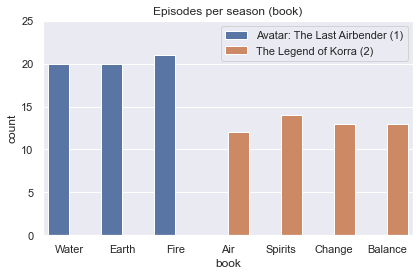

In [28]:
sns.countplot(x='book', hue='series', data=episode_info_df)
plt.yticks([i * 5 for i in range(6)])

plt.legend(labels=['Avatar: The Last Airbender (1)', 'The Legend of Korra (2)'])
plt.title('Episodes per season (book)')
plt.tight_layout()
plt.show()

The above plot shows that the first series contains one fewer season, but has on average more episodes per season than the second series. 
Additionally, the number of *total* episodes per series is also shown below:

In [29]:
episode_info_df.groupby('series').count().drop(columns=['Unnamed: 0', 'name', 'book_number', 'episode_number'])

,book
series,
1,61
2,52


*Avatar: The Last Airbender* has $61$ episodes, while *The Legend of Korra* has $52$ episodes. This makes the first series slightly longer in terms of running time, since each episode has a running time of approx. 20 minutes. We investigate these numbers to ensure a fair comparison of the two series later on.

### Number of words spoken per book
We saw that the two series are close to equal in episode count, but how does the dialogue differ in terms of length?

In [30]:
transcript_df = transcript_df.dropna()

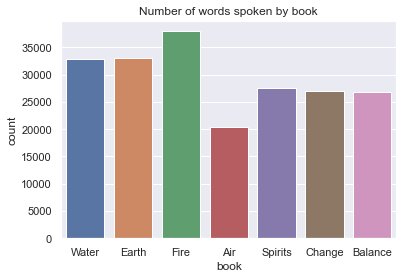

In [31]:
dialogue = transcript_df[['book', 'dialogue']]

num_tokens = []
for book_name in transcript_df['book'].unique():
    book_dialogue = transcript_df[transcript_df['book'].str.contains(book_name[0])]
    book_text = ' '.join(book_dialogue['dialogue'])
    
    # Extract tokens (also removes punctuation)
    tokenizer = nltk.RegexpTokenizer(r'[\w\']+')
    tokens = tokenizer.tokenize(book_text)
    
    # Convert to lower case
    tokens = [token.lower() for token in tokens]
    num_tokens.append(len(tokens))

sns.barplot(y=num_tokens, x=list(transcript_df['book'].unique()))

plt.title('Number of words spoken by book')
plt.ylabel('count')
plt.xlabel('book')
plt.show()



We find that the above results are consistent with the episode counts found previously. It makes sense that a higher episode count results in a higher amount of dialogue.
Arguably, the above is a trivial observation. Let us normalize the token count by the number of episodes to get a more telling result.

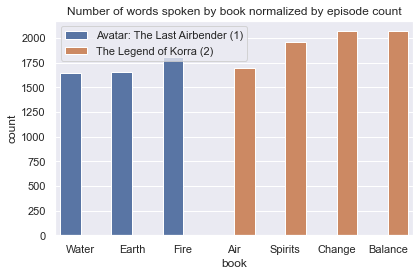

In [32]:
num_tokens_normalized = []
for book_name, token_count in zip(transcript_df['book'].unique(), num_tokens):
    episode_count = len(episode_info_df[episode_info_df.book == book_name])
    token_count_normalized = token_count / episode_count
    num_tokens_normalized.append(token_count_normalized)

tk_norm_df = pd.DataFrame({'tokens_norm': num_tokens_normalized, 'series': [1, 1, 1, 2, 2, 2, 2], 'book': transcript_df['book'].unique()})

sns.barplot(y='tokens_norm', hue='series', x='book', data=tk_norm_df)
legend = plt.legend()
legend.get_texts()[0].set_text('Avatar: The Last Airbender (1)')
legend.get_texts()[1].set_text('The Legend of Korra (2)')
plt.title('Number of words spoken by book normalized by episode count')
plt.ylabel('count')
plt.xlabel('book')

plt.tight_layout()
plt.show()

The above plot is more meaningful. Clearly, *The Legend of Korra* contains more dialogue on average per episode when compared to *Avatar: The Last Airbender*. Each episode of *The Legend of Korra* appears to be more densely packed. It will be interesting to see the implications of this in the subsequent analysis. 

### Word frequency by season

Here we will determine the most common words in each book. There's a good chance that this will mostly include stop words, but it will be interesting to compare each book nonetheless.

In [33]:
from functools import reduce

dialogue = transcript_df[['book', 'dialogue']]

word_freqs = []
for book_name in transcript_df['book'].unique():
    book_dialogue = transcript_df[transcript_df['book'].str.contains(book_name[0])]
    book_text = ' '.join(book_dialogue['dialogue'])
    
    # Extract tokens (also removes punctuation)
    tokenizer = nltk.RegexpTokenizer(r'[\w\']+')
    tokens = tokenizer.tokenize(book_text)
    
    # Convert to lower case
    tokens = [token.lower() for token in tokens]
    
    word_freqs.append(nltk.FreqDist(tokens))
    
dfs = []
for word_freq, book_name in zip(word_freqs, transcript_df['book'].unique()):
    dist = word_freq.most_common(10)
    
    # Adding a suffix for each word count
    df = pd.DataFrame({'word': [word for (word, _) in dist], 'count_' + book_name: [str(count) for (_, count) in dist]})
    dfs.append(df)


# 7-way outer merge
reduce(lambda left, right: pd.merge(left, right, on='word', how='outer'), dfs)

,word,count_Water,count_Earth,count_Fire,count_Air,count_Spirits,count_Change,count_Balance
0,the,1225,1285,1367,823,1166,928,931
1,you,1197,1171,1388,653,1001,908,975
2,to,920,979,1009,558,819,836,882
3,i,916,864,1342,539,825,803,907
4,a,620,600,673,370,416,489,419
5,and,414,487,640,323,429,468,494
6,it,398,423,505,NaN,261,NaN,249
7,of,388,472,439,271,363,369,353
8,is,358,405,382,239,322,267,NaN
9,that,340,NaN,NaN,NaN,NaN,NaN,251


The above table shows the top 10 most common words for each book. Note that the table actually has 13 rows, since not all books has the same words in their top 10. `NaN` values indicate words that are not part of that book's top 10. The number of rows is actually interesting, since it is close to 10. This means that each book generally has the same words in common. As expected, the distribution almost exclusively contains stop words, since these were not filtered up.

### Most connected characters (total degree)
We'll now be taking a look at some descriptive statistics of the network. Firstly, we would like to examine the most connected characters, and see if they are what we expect.

In [34]:
degree_list = sorted(GCC.degree(), reverse=True, key=lambda pair: pair[1])
for idx, (name, links) in enumerate(degree_list[:10]):
    print(str(idx + 1) + '.', name, 'with', links, 'links')


1. Aang with 349 links
2. Katara with 287 links
3. Sokka with 284 links
4. Zuko with 240 links
5. Toph Beifong with 208 links
6. Korra with 202 links
7. Tenzin with 155 links
8. Bolin with 147 links
9. Mako with 140 links
10. Iroh with 137 links


There are close to no surprises here in terms of total degree. The top 5 includes the most well known characters of the series, the core part of the original *Team Avatar*: *Aang*, *Katara*, *Sokka*, *Zuko* and *Toph*. Interestingly, Aang, the main character of the first series is not so far ahead in terms of links of the supporting cast. 

*Korra*, the main character of the second series *The Legend of Korra*, lands at 6th place with $202$ links. It appears the she interacted with less characters overall. This perhaps give us a clue of the differences between the two series. The remaining characters are also mainly associated (expect *Iroh*) with the second series, reinforcing this point. We also know from earlier that *The Legend of Korra* contains less episodes, so this could be a reasonable explanation.

We also wish to explore the in-degrees and out-degree separately to see if this will shed further light on the situation.

In [35]:
out_deg = [G.out_degree(node_name) for node_name in G.nodes]
in_deg = [G.in_degree(node_name) for node_name in G.nodes]
in_out_deg = [x + y for x, y in zip(out_deg, in_deg)]

### Most connected characters (in-degree)

In [36]:
in_degree_list = sorted(GCC.in_degree(), reverse=True, key=lambda pair: pair[1])
for idx, (name, links) in enumerate(in_degree_list[:10]):
    print(str(idx + 1) + '.', name, 'with', links, 'in-links')

1. Aang with 266 in-links
2. Sokka with 205 in-links
3. Katara with 201 in-links
4. Zuko with 167 in-links
5. Korra with 139 in-links
6. Toph Beifong with 136 in-links
7. Iroh with 91 in-links
8. Tenzin with 91 in-links
9. Bolin with 89 in-links
10. Appa with 84 in-links


The in-degree tells the same story. Characters only move a place or two. It is interesting to see that *Appa* is the character with the 10th largest in-degree with $84$ links! 
Appa is a flying bison (i.e. non-human) that cannot talk. He is used as the primary means of transporation in the first series. It is amusing that a character which cannot even directly communicate with other characters has such a large in-degree.

### Most connected characters (out degree)

In [37]:
out_degree_list = sorted(GCC.out_degree(), reverse=True, key=lambda pair: pair[1])
for idx, (name, links) in enumerate(out_degree_list[:10]):
    print(str(idx + 1) + '.', name, 'with', links, 'out-links')

1. Katara with 86 out-links
2. Aang with 83 out-links
3. Sokka with 79 out-links
4. Zuko with 73 out-links
5. Toph Beifong with 72 out-links
6. Tenzin with 64 out-links
7. Korra with 63 out-links
8. Lin Beifong with 63 out-links
9. Jinora with 60 out-links
10. Bolin with 58 out-links


There is a single interesting aspect here. Both *Aaag* and *Korra* (main characters) are outdone by major characters in their respective series. This is *Katara* and *Tenzin* respectively.

### In-degree distribution

It is crucial we examine the degree distribution of our network to determine its characteristics. We expect our network to obey power laws, since we are dealing with a social network. However, it will be interesting to see if any individual degrees follow a poisson distribution.

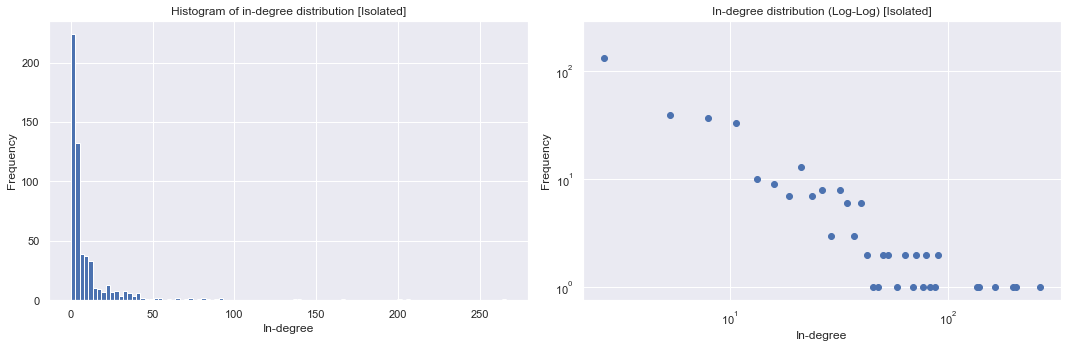

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

hist, bins = np.histogram(in_deg, bins=100)
axes[0].hist(bins[:-1], bins, weights=hist)
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('In-degree')
axes[0].set_title('Histogram of in-degree distribution [Isolated]')

axes[1].plot(bins[:-1], hist, 'bo')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('In-degree')
axes[1].set_title('In-degree distribution (Log-Log) [Isolated]')

plt.tight_layout()
plt.show()

The above is in line with what we expect. We see that the number of degrees is highly disproportinate between chararcters, with most characters having close to 0 degree. There are also a few characters with an extremely high degree. The log-log plot shows a straight line, indicating that the in-degree follows a power law and likely is a scale-free network.


### Out-degree distribution

We now examine the out-degree distribution as before.

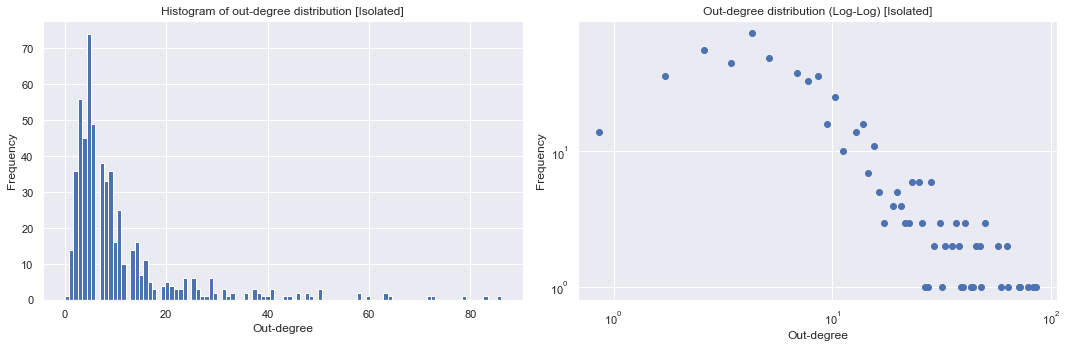

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

hist, bins = np.histogram(out_deg, bins=100)
axes[0].hist(bins[:-1], bins, weights=hist)
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Out-degree')
axes[0].set_title('Histogram of out-degree distribution [Isolated]')

axes[1].plot(bins[:-1], hist, 'bo')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Out-degree')
axes[1].set_title('Out-degree distribution (Log-Log) [Isolated]')

plt.tight_layout()
plt.show()

The out-degree is not as clear cut as the in-degree. The log-log plot is not completely straight, but instead has a kind of parabola shape. However, it looks like the vast majority of nodes are still present on the straight line to the right. The histogram also shows that the distribution is not quite as uneven as for the in-degree.

### Total degree distribution

For further clarity, we also look at the total degree below.

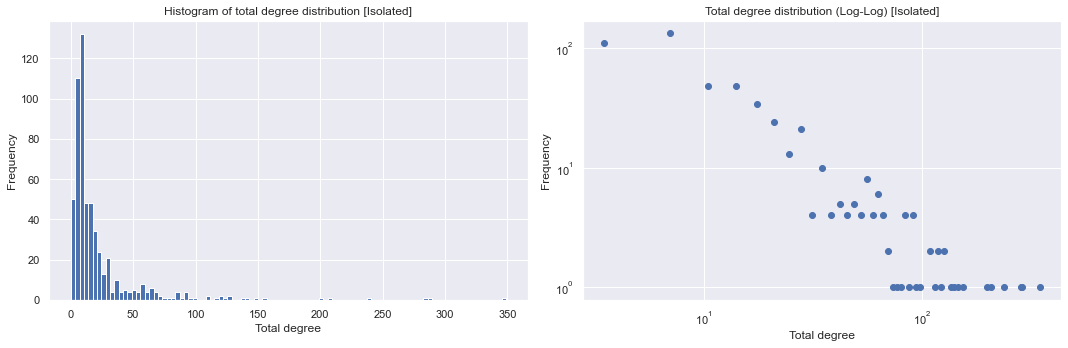

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

hist, bins = np.histogram(in_out_deg, bins=100)
axes[0].hist(bins[:-1], bins, weights=hist)
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Total degree')
axes[0].set_title('Histogram of total degree distribution [Isolated]')

axes[1].plot(bins[:-1], hist, 'bo')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Total degree')
axes[1].set_title('Total degree distribution (Log-Log) [Isolated]')

plt.tight_layout()
plt.show()

The total degree is more akin to the in-degree plots. This is expected, since the in-degree is much higher than the out degree. Based on the three degree distributions, it would not be far fetched to consider the network scale-free. It is characterized by an extremely disproportiate degree distribution, with a few nodes serving as hubs with massive degrees.

### Exponent of degree distributions

Even given the above, we wish to further reinforce our point. Therefore, we will examine $\alpha$, the degree exponent. If our network truly is scale-free, we expect that $2 \lt \alpha \lt 3$. 

In [41]:
in_deg_exponent = powerlaw.Fit(in_deg, verbose=False).alpha
out_deg_exponent = powerlaw.Fit(out_deg, verbose=False).alpha

print('In-degree exponent:', in_deg_exponent)
print('Out-degree exponent:', out_deg_exponent)

In-degree exponent: 2.7162278098536237
Out-degree exponent: 2.521860184562475


/Users/philip/opt/anaconda3/envs/socialgraphs/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


The in-degree exponent is $\alpha_{in} = 2.72$ and the out-degree exponent is $\alpha_{out} = 2.52$. This confirms that our network is scale-free, by being in the *ultra-small world* regime. This is exactly because it holds that $2 \lt \alpha_{in} \lt 3$ and $2 \lt \alpha_{out} \lt 3$. We can also certainly say that our network is **not** a random network.

### Attribute distributions

This section will briefly look at the distributions of character attributes.

#### Distribution of nationalities

We know that nationality is important in ATLA, but what is the representation of each nationality? Some nationalities are naturally smaller in terms of population, meaning that they will appear underrepresented.

In [42]:
nationalities = [attribs['nationality'] for _, attribs in G.nodes(data=True)]

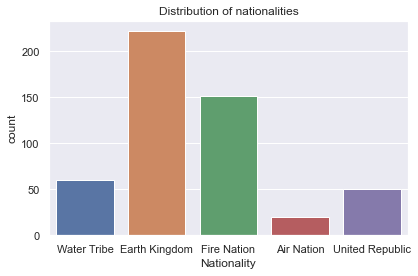

In [43]:
sns.countplot(x=nationalities)

plt.xlabel('Nationality')
plt.title('Distribution of nationalities')

plt.tight_layout()
plt.show()

We see that the Earth Kingdom is by far the most represented nation, but the Fire Nation following behind in second. It makes sense that the Water Tribe and Air Nation are small, since they are much closer to tribes found in the real world. We cannot actually say that the Earth Kingdom has a larger population than the Fire Nation from the above. What we can say however, is that the main characters of both series interact with characters from the Earth Kingdom to a greater degree.

#### Distribution of gender

ATLA has been praised for inclusion and handling of social issues in the past. It will be interesting to see if the gender representation will be close to 50-50 or something else entirely.

In [44]:
genders = [attribs['gender'] for _, attribs in G.nodes(data=True)]

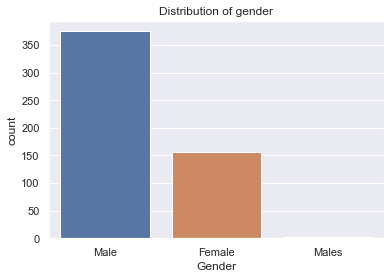

In [45]:
sns.countplot(x=genders)

plt.title('Distribution of gender')
plt.xlabel('Gender')
plt.show()

This result is a bit surprising. It appears that male characters far outweigh the female characters by a factor of more than 2. Determining why this is the case is difficult. In the end, it comes up to how the writers determined to frame the show.

#### Distribution of bending styles
Here we will most likely see results similar to that of the nationality distribution. However, here we will also be also to gauge the number of non-benders in the ATLA universe.

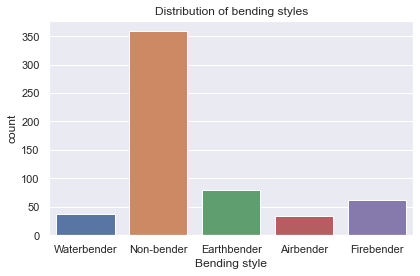

In [46]:
benders = [attribs['bending_art'] for _, attribs in G.nodes(data=True)]

sns.countplot(x=benders)

plt.xlabel('Bending style')
plt.title('Distribution of bending styles')

plt.tight_layout()
plt.show()

As we can see, the *vast* majority of characters are non-benders. This gives us an interesting aspect of the series. Mastering a bending art is rare, and most common folk will never master it. It is also expected that this plot is similar to the distribution of nationalities. Characters from the Earth Kingdom are typically earthebenders and so on.

### Visualizing the network

In this part we will finally be visualizing the network. We hope display the network such that meaningful information can be extracted. For this part, we will be using the undirected version of the GCC.

We'll be using `ForceAtlas2` for finding node positions.

In [47]:
GCC_undirected = GCC.to_undirected()

We wish to color each node according to the `nationality` attribute. The Earth Kingdom is green, Fire Nation is red, Water Tribe is blue and Air Nation is grey, United Republic is purple and nodes without a nation are black.

In [48]:
color_map = []
for node, attribs in GCC_undirected.nodes(data=True):
    if attribs['nationality'] == 'Earth Kingdom':
        color_map.append('#5F974E')
    elif attribs['nationality'] == 'Fire Nation':
        color_map.append('#e64358')
    elif attribs['nationality'] == 'Water Tribe':
        color_map.append('#2E67A0')
    elif attribs['nationality'] == 'Air Nation':
        color_map.append('#bee5fd')
    elif attribs['nationality'] == 'United Republic':
        color_map.append('purple')
    else:
        color_map.append('black')

We also want the size of nodes to be exponentially correlated with degree. This will help visualize hubs in the network. Naturally, the exponent will be small to avoid explosive node growth. In this case, we have chosen $1.3$. 

In [49]:
degree_dict = dict(GCC_undirected.degree)
node_sizes = [n ** 1.3 for n in degree_dict.values()]

It is helpful to have node labels for hubs to recognize key characters. We say that if $d \ge 100$, that node's label is shown.

In [50]:
labels = {}

for n in GCC_undirected.nodes():
    label = n

    # Make Toph's name a bit smaller to make it fit on the plot
    if str(label) == 'Toph Beifong':
        label = 'Toph'

    if GCC_undirected.degree[n] >= 100:
        labels[n] = label
    else:
        labels[n] = ''

Edges are also colored. If characters of the same nationality are connected, the edge is colored with the nationality color described above.

In [51]:
edge_colors = []

for n1, n2 in GCC_undirected.edges():
    n1_nat = GCC.nodes[n1]['nationality']
    n2_nat = GCC.nodes[n2]['nationality']
    
    if n1_nat == n2_nat:

        if n1_nat == 'Water Tribe':
            edge_colors.append('#2E67A0')
        elif n1_nat == 'Earth Kingdom':
            edge_colors.append('#5F974E')
        elif n1_nat == 'Fire Nation':
            edge_colors.append('#e64358')
        elif n1_nat == 'Air Nation':
            edge_colors.append('#bee5fd')
        elif n1_nat == 'United Republic':
            edge_colors.append('purple')
    else:
        edge_colors.append('black')

Finally, we can combine the above and visualize the network.

In [52]:
fa2_object =  ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=2,

                        # Log
                        verbose=False)


positions = fa2_object.forceatlas2_networkx_layout(GCC_undirected, pos=None, iterations=2000)

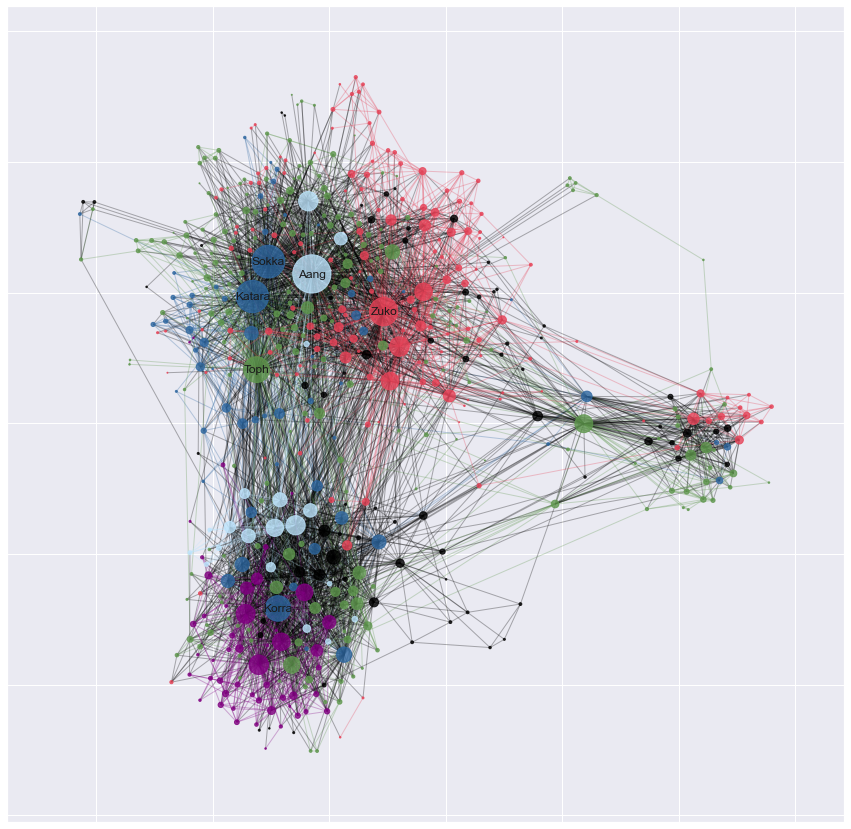

In [53]:
plt.figure(3, figsize=(15,15))
nx.draw_networkx_nodes(GCC_undirected, positions, node_color=color_map, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(GCC_undirected, positions, edge_color=edge_colors, alpha=0.3)
nx.draw_networkx_labels(GCC_undirected, positions, labels, font_size=12)
plt.show()

What first comes to mind from the above visualization is how extremely connected the network is. There is a large number of edges all around, making it difficult to discern individual edges. There are also very few "lines" of connected nodes of low degree. This indicates that the entire cast of ATLA are well connected.

The hub structure of a scale-free network is easily present. We have six hubs, consisting of the characters *Aang*, *Sokka*, *Katara*, *Toph*, *Zuko* and *Korra*. These are the most prevalent characters of both series, making their hub status expected.

There appears to be three clusters in total. One to left, one to the right and a smaller one at the top. It is in particular the two larger clusters that are interesting. It seems that these two clusters effectively separate characters from each series. There are several reasons for this. Firstly, *Korra* is the main character of *The Legend of Korra* and belongs in her own cluster, with the remaining hubs residing in the other cluster. The clusters also contain a high density of edges, which is expected since they would interact frequently if within the same series. We also exclusively see *United Republic* characters in *Korra*'s cluster, since this nation was not introduced until the second series. There is also a degree of interconnectivity between the two clusters, since both series are in the same universe and time period.

## Tools, theory and analysis

### Word clouds and nationality

In the ATLA universe, there is a strong emphasis on nationality. The conflicts within the series are based on the constrasting interests between nations. For example, the Fire Nation has in recent years been known to be especially millitant and aggressive, so it will be interesting to see if these beliefs will be confirmed. On the other hand, the Air Nation is known to consist of peaceful monks, inspired by Buddhist monks in the real world. 

Our tool of choice for this task is *word clouds*. Word clouds are visual collections of words from text documents, where the size of the word indicates their importance according to some metric. This can help us locate key words for each nation. We will be using the wiki character pages as text for this purpose.

We'll first be cleaning the character pages. We are using the plain text character pages for this purpose, to avoid any additional cleaning. The cleaning process involves removing wiki headers and other character names. Whilst tokenizing the text, we are also removing stop words, lemmatizing and removing capital letters.

This whole process takes over an hour usually. Therefore, we are saving the cleaned text as text files in case of kernel restarts.

In [54]:
def clean_text(name,df):
    if name == "Dock/Xu/Bushi": #Special case for name
        name = "Dock-Xu-Bushi"
    path = 'characters_cleaned_text/'
    if not os.path.exists(path):
        os.makedirs(path)
    #print("Cleaning name: ",name)
    with open('characters_plain_text/' + name + '.txt', "r+") as f:
        text = f.read() # Read content of file
        text = re.sub('\=+[\w\s]+\=+',"",text) # Remove headers with format  = header = ,== header ==,etc
        
    for char in df.name:
        text = re.sub(char,"",text) # Remove all names from content
        
    tokens = word_tokenize(text) # Tokenize the text
    clean_text = [word for word in tokens if not word in stopwords.words() and word.isalpha() and len(word)>1] # Clean from stopwords and making sure that its not a special character
    clean_lemmas_text = [WordNetLemmatizer().lemmatize(token) for token in clean_text] # Lematize words
    final_clean_text = [word.lower() for word in clean_lemmas_text] # Remove capital letters

    with open('characters_cleaned_text/' + name + '.txt', "w") as f:
        for token in final_clean_text:
            f.write(token + "\n") # Save tokens 
        f.close()
            
for name in data.name:
    clean_text(name,data)

Next, we will for every nationality join the text into a corpus.

In [55]:
nat_dict = {}
words = []
for nat in data.nationality.unique():
    nat_text = []
    for name in data[data["nationality"] == nat].name:
        if name == "Dock/Xu/Bushi":
            name = "Dock-Xu-Bushi"
        with open ('characters_cleaned_text/' + name + '.txt', "r") as f:
            text = f.read()
            tokens = text.split("\n")
            tokens = list(filter(None, tokens)) #Remove empty space as token
            nat_text.extend(tokens)
    nat_dict[nat] = nat_text
    words.extend(nat_text)
    
vocab = sorted(list(set(words)))

The following code block defines helper functions used for calculating various term frequency statistics. Please refer to the individual functions for a short explanation of each.

In [56]:
def get_tf(doc):
    """Get TF of a document. 

    Returns a dictionary. 
    """ 
    tf_dict = {}
    counts = Counter(doc)
    for item in counts.keys():
        tf_dict[item] = counts[item] / len(doc)
    return tf_dict

def get_tc(doc):
    """Get TC of a document. 

    Returns a dictionary. 
    """
    tc_dict = {}
    counts = Counter(doc)
    tc_dict = dict(counts)
    return tc_dict

def get_idf(nat_dict,vocab):
    """Get IDF from a number of documents. 

    Returns a dictionary. 
    """
    idf_dict = {}
    D = len(nat_dict)
    for word in vocab:
        counter = 0
        for nat in nat_dict:
            if word in nat_dict[nat]:
                counter += 1
        idf_dict[word] = math.log((D/counter),10)
    return idf_dict

def get_tc_idf(tc_dict,idf_dict,nat_dict):
    """Get TC-IDF of a document. 

    Returns a dictionary. 
    """
    tc_idf = {}
    for nat in nat_dict:
        tc_idf[nat] = {}
        for word in nat_dict[nat]:
            tc_idf[nat][word] = tc_dict[nat][word] * idf_dict[word]
    return tc_idf

def get_tf_idf(tf_dict,idf_dict,nat_dict):
    """Get TF-IDF of a document. 

    Returns a dictionary. 
    """
    tf_idf = {}
    for nat in nat_dict:
        tf_idf[nat] = {}
        for word in nat_dict[nat]:
            tf_idf[nat][word] = tf_dict[nat][word] * idf_dict[word]
    return tf_idf


def get_score_by_tc(doc,nat,tc_dict,idf_dict):
    """Get Scores of words in a document based on rounding TC-IDF values. 

    Returns a dictionary.
    """
    score = {}
    for word in doc:
        score[word] = math.ceil(tc_dict[nat][word] * idf_dict[word])
    return score

def get_score_by_tf(doc,nat,tf_dict,idf_dict):
    """Get Scores of words in a document based on rounding TF-IDF values. 

    Returns a dictionary.
    """
    score = {}
    for word in doc:
        score[word] = math.ceil(tf_dict[nat][word] * idf_dict[word])
    return score
        
def get_top_words(data, n):
    """Get top n words by value (score) . 

    Returns a dictionary.
    """ 
    top = sorted(data.items(), key=lambda x: x[1], reverse=True)[:n]
    return dict(top)

tc = {}
tf = {}
idf = {}


Here we are calculating the IDF, TC-IDF and TF-IDF for each corpus containing text related to a nationality.

In [57]:
for nat in nat_dict:
    tc[nat] = get_tc(nat_dict[nat])
    tf[nat] = get_tf(nat_dict[nat])

idf = get_idf(nat_dict,vocab)
tc_idf = get_tc_idf(tc,idf,nat_dict)
tf_idf = get_tf_idf(tf,idf,nat_dict)

scores = {}
top_words = {}
for nat in nat_dict:
    scores[nat] = get_score_by_tf(nat_dict[nat],nat,tf,idf)
    top_words[nat] = get_top_words(scores[nat],n=len(scores[nat]))

With the above done, we can display word clouds for each nationality. We decided on using TF-IDF to measure the importance of invidiual words, as this gave us the best results.
It is also helpful that TF contains normalization, since the text documents for each nationality are not of equal length.

For additional flair, we are also shaping our word cloud based on each nations element.

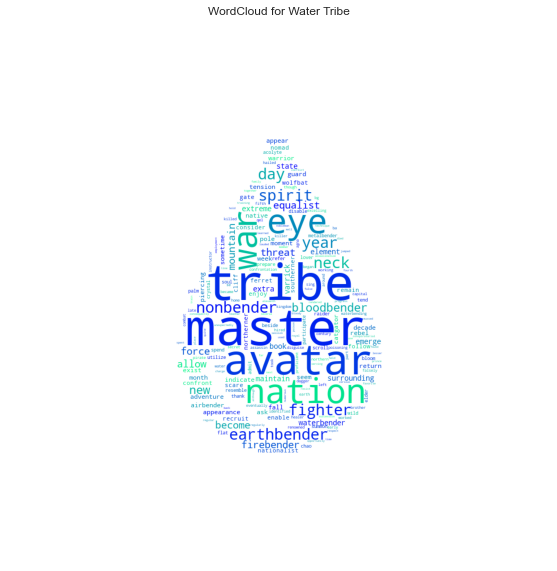

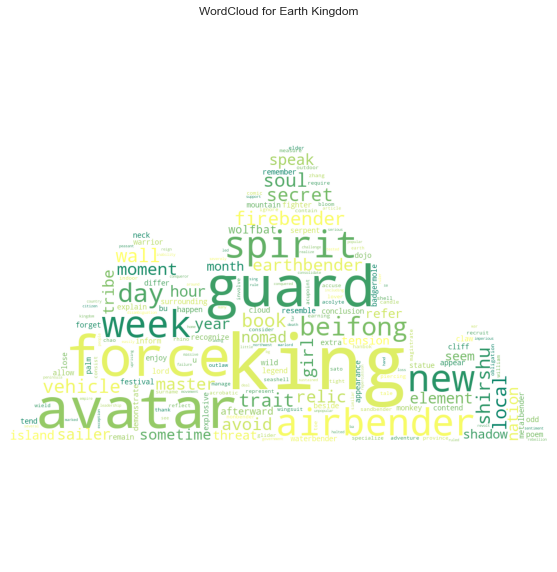

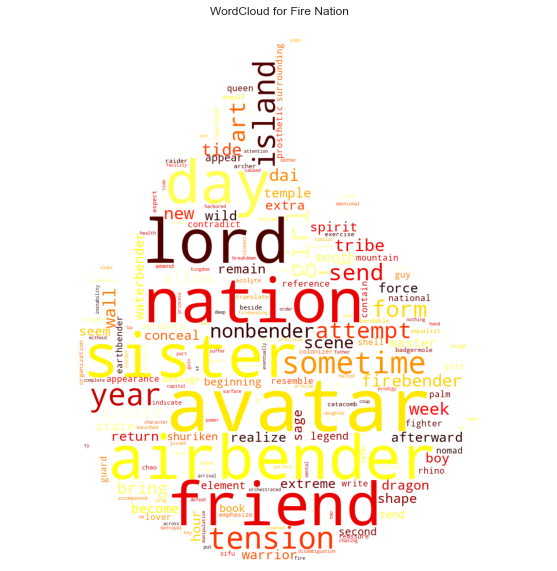

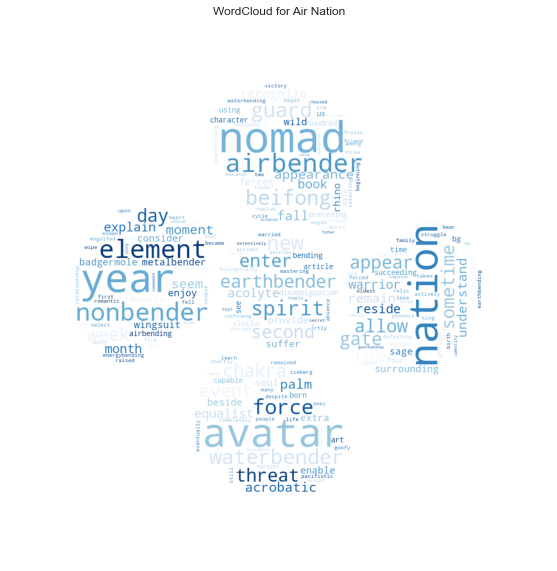

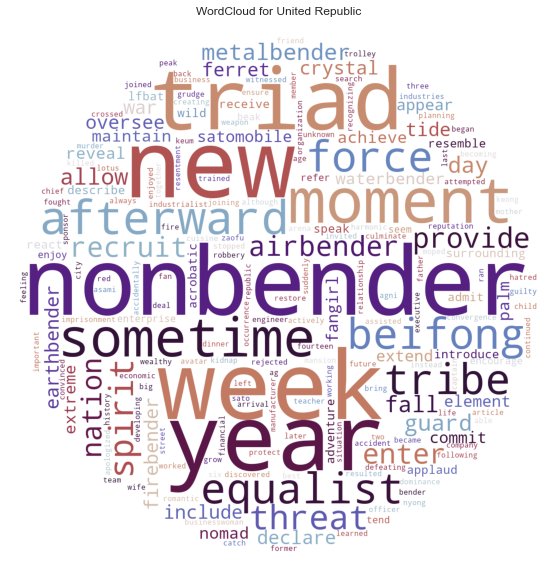

In [58]:
import PIL as PIL
colormap = ['winter','summer','hot','Blues', 'twilight']    
nat_list = list(data.nationality.unique())

def create_wordcloud(nat,color,scores):
    rep_words = ''
    word_string = ''
    nat_image = PIL.Image.open('word_logos/'+str(nat)+'.jpg')
    nat_image_array = np.array(nat_image)
    for i,word in enumerate(scores[nat]):
        for n in range(scores[nat][word]):
            rep_words = rep_words + word + ' '
    word_string = word_string + rep_words + ' '
    wordcloud = WordCloud(width=800, height=400, background_color = "white",colormap=color,collocations = False,mask=nat_image_array).generate(word_string)
    plt.figure(figsize=(20,10))
    img=plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("WordCloud for " +  nat)
    plt.show()
    
    
for nat,color in zip(nat_list,colormap):
    create_wordcloud(nat,color,scores)

Above we see word clouds for all five nations. This section will analyze our findings.

**Water Tribe**

The Water Tribe is a hunter-gatherer society, based on the inuit tribes of the northern hemisphere. The fact that they are hunters also means that they are capable of fighting. We see this clearly in the word cloud, with a lot of words related to combat: *warrior*, *tribe*, *guard*, *fighter* and so on. There are also references to the bending arts. It is notably that the signature bending style of the Water Tribe, waterbending, is not particularly emphasized. Earthbending appears to claim the spot of most emphasized bending art. The top four words are *tribe*, *avatar*, *nation* and *master*. Unfortunately, these words do not give much insight into the Water Tribe, as they are relatively generic.

**Earth Kingdom**

The Earth Kingdom, a monarchy, is the largest nation in terms of land mass. It is also economically prosperous, based on extensive agriculture and industry. The Earth Kingdom was extensively targeted in the so-called *Hundred Year War* started by the Fire Nation due to their power. The monarchy is represented in the word cloud by the words *king*, *guard* and *wall*. There are also words directly related to the war, such as *force*, *threat* and *tension*. Generally, it is difficult to extract concrete characteristics from this word cloud. It could be beacuse the Earth Kingdom is so vast with a diverse cast of characters.

**Fire Nation**

The leader of the Fire Nation is deemed the *lord*, explaining why it is so prominent on the word cloud. The word *sister* is most certainly emphasized due to the character *Azula*, the egotistical sister of *Zuko*, another main character of the series. She plays a key role throughout the series, often sabotaging the main characters in various ways. We find it surprising that the Fire Nation word cloud does not contain aggressive and combatant terms to a large degree. We do see words like *force*, *tension* and *firebender*, but these are not overly harsh words. This tells us that perhaps attributing the Fire Nation as warmongers is unfair. We should also recall that our corpus consists of *all* Fire Nation characters. The nation's leaders can still be invasive and imperialistic, while the common folk can be peaceful and kind. 

**Air Nation**

The top word is *nomad*, which precisely is the status of the Air Nation's inhabitants. The Air Nation is known to have a relative large degree of benders (when compared to other nations), explaining why *airbender* is high on the list. Regardless, *nonbender* is still prominent. In terms of spiritual terms, we see *chakra*, *spirit*, *sage* and *cycle*. 

**United Republic**

The United Republic is special, since it is an amalgamation of the previous four nations. It was created during *The Legend of Korra*, making it a young nation. We feel that the diversity of the republic is represented in the word cloud. There are *a lot* of different terms that are only vaguely related. Many of the words from the previous word clouds are present. The most prominent word is *nonbender*, indicating that the republic contains a large degree of nonbenders. We can also see some of the nation's issues through *gangster*, *triad*, *equalist*, *robbery*, *hatred*, *killed* and *imprisonment*. Equalists are a radical group against benders, while triads are groups of gangsters. We see a focus on business and industry as well with *business*, *industry*, *wealthy*, *economic*, *future* and *enterprise*. 

**Conclusion**

Overall, we do not feel that the word clouds were particularly insightful. Sometimes interesting key words did appear, but it also felt like we saw a lot of filler words.
The most interesting word cloud was definitely the United Republic, which provided a lot of interesting, non-trivial words. We could easily see the conflicts and characteristics of the nation. On the other hand, we see the Earth Kingdom word cloud, which did not provide much. 

It would have been interesting to perform the same experiment, but using character dialogue instead. We could also have tried to constrain the words included to adjectives and adverbs.





### Communities

Communities are a way of partitioning a network into several distinct groups. Each group contains nodes that are *densely interconnected*. In our case, we will be employing the *Louvain algorithm* for communicty detection, both due to its ease of use and runtime. It is also easy to verify the effectiveness of the partitions through the *modularity* construct.

In this section, we are interested in exploring communities in the ATLA universe. Firstly, we want to explore whether the presence of communities can be justified. We also want see if it is true that characters of the same nationality generally flock together. It would also be interesting to see how the community detection algorithm handles the distinction between *Avatar: The Last Airbender* and *The Legend of Korra*. Ultimately, the series shame some amount of characters, so this could shed light on which series a character primarily belongs to. In the end, we will also perform sentiment analysis on these groups to see if any communities stand out.

In [59]:
avatar_graph = GCC_undirected

In [60]:
from community import community_louvain
def find_communities_from(graph):
    '''
    Finding the communities, plotting them and printing the count.
    '''
    partition = community_louvain.best_partition(graph,random_state=33)
    count = len(set(partition.values()))
    
    print(f'No. of found communities: {count}')
    
    return partition

def set_community_attribute(graph, attributes):
    '''
    Function for setting the community attribute to the character node.
    '''
    for char in graph.nodes():
        graph.nodes[char]['community'] = attributes[char]

    return graph


def plot_community_distribution(communities):
    '''
    Plot the distribution of the communities in chosen universe.
    '''

    data = [value for _, value in communities.items()]
    title = 'Communitiy size distribution'
    caption = 'The histogram represents the number of members\nassigned to each community.'
    values, bins = np.histogram(data, range(len(set(communities.values()))+1))
    plt.bar(bins[:-1], values, width=0.5)
    plt.title(title)
    plt.xlabel('Community number')
    plt.ylabel('Count')
    plt.xticks(range(len(set(communities.values()))))
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.tight_layout()
    plt.show()
    


In [61]:
avatar_communities = find_communities_from(avatar_graph)

No. of found communities: 6


After the partitioning, we find $7$ communities in total. In order to determine the soundness of the partitions, we will also explore the modularity.

In [62]:
modularity = community_louvain.modularity(avatar_communities,avatar_graph)
print("Modularity of the communities partition using the Louvain algorithm is: ", modularity)

Modularity of the communities partition using the Louvain algorithm is:  0.48566973370417044


The modularity is found to be $M = 0.49$. Considering that it must hold that $M \leq 1$ and that we are relativelyt close to this value, we consider this partition to be satisfactory.

#### Distributions and visualization

In this section, we will examine attribute distribution and visualize the communities.

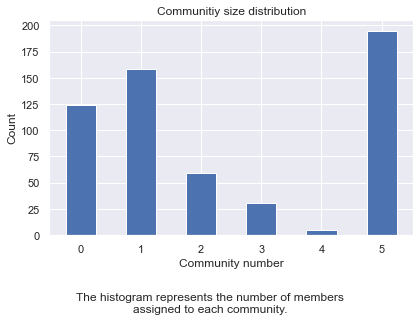

In [63]:
avatar_graph = set_community_attribute(avatar_graph,avatar_communities)
plot_community_distribution(avatar_communities)

The above shows the distribution of community sizes. We clearly see all 7 communities represented. The communities are of varying sizes, with three communities boasting over 100 members. The three smallest communities have less than 25 members each. 

While the above gives us an idea of the communities, we wish to explore further. One of our goals was to see if nationalities flocked together.

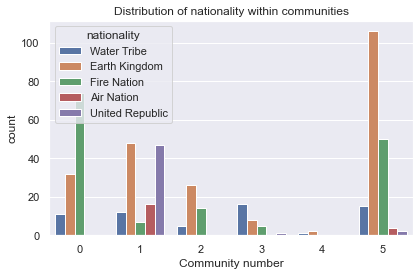

In [64]:
comms = [comm for _, comm in avatar_communities.items()]
names = [name for name, _ in avatar_communities.items()]
nats = [n[1]['nationality'] for n in GCC.nodes(data=True)]

comm_df = pd.DataFrame({'name': names, 'community_number': comms, 'nationality': nats})

sns.countplot(data=comm_df, x='community_number', hue='nationality')
plt.xlabel('Community number')
plt.title('Distribution of nationality within communities')

plt.tight_layout()
plt.show()


Here we see the same plot as before, but with each community split by its nationality. The results somewhat confirm our hypothesis. Almost all communities have a nationality that is overrepresented. The only expection is community $1$, which is also the only community to contain a large number of United Republic members. This is a clear indicator that community $1$ encapsulates characters from *The Legend of Korra*.

In order to solidify our findings, we will revisualize our network from earlier. This time however, nodes will be colored according to the community they belong to.

In [65]:
# Color according to community
community_color_map = []
colors = ['red', 'blue', 'yellow', 'green', 'pink', 'black', 'grey']

for n in GCC_undirected.nodes(data=False):
    comm = avatar_graph.nodes(data=True)[n]['community']
    community_color_map.append(colors[comm])

# Show a bit more labels than previously
comm_labels = {}
for n in GCC_undirected.nodes():
    label = n

    # Shorten some names
    label = label.split(' ')[0]

    if GCC_undirected.degree[n] >= 70:
        comm_labels[n] = label
    else:
        comm_labels[n] = ''

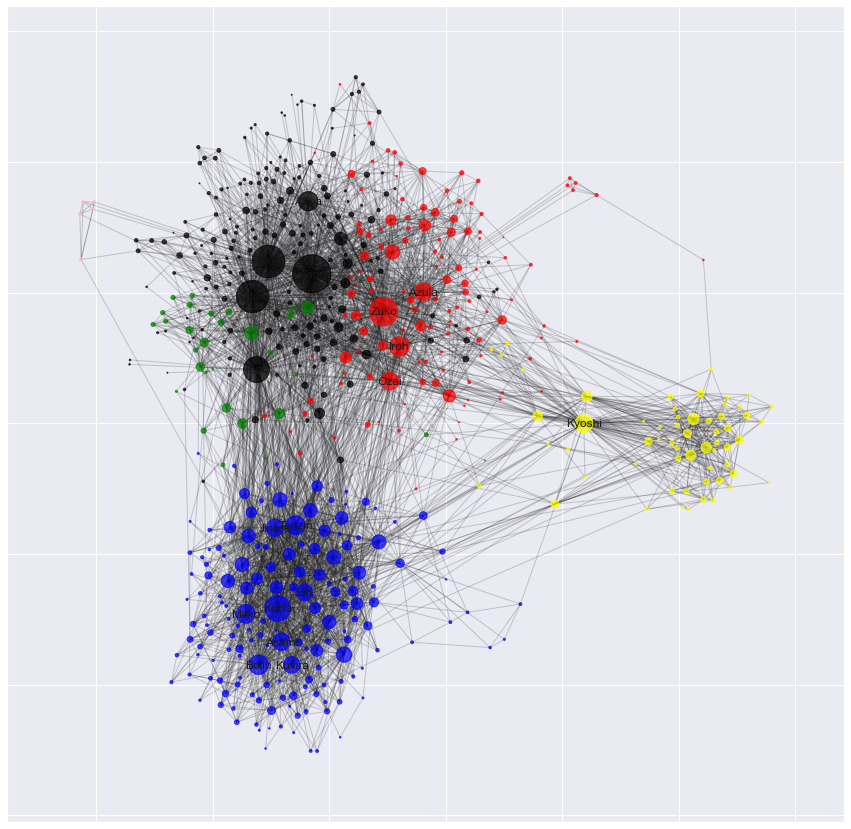

In [66]:
plt.figure(3, figsize=(15,15))
nx.draw_networkx_nodes(GCC_undirected, positions, node_color=community_color_map, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(GCC_undirected, positions, alpha=0.2)
nx.draw_networkx_labels(GCC_undirected, positions, comm_labels, font_size=12)
plt.show()

The above visualization is impactful. Based on the labels, we can see that the Louvain method managed to accurately partition characters between the two series. All the nodes in the blue community are directly associated with *The Legend of Korra*, while the rest have a role in both series (albeit mostly the first). 

The green community managed to capture the first 5 members of the original *Team Avatar* which the first series focuses on. In the yellow community, we also see members of the royal Fire Nation family.

It is also interesting to see how well the original node positions from the `ForceAtlas2` algorithm managed to capture communities.

#### Top 5 TF-IDF terms of communities

Finally, we will try to further characterize the communities by determining their top 5 terms according to TF-IDF. 

In [67]:
def get_biggest_communities(communities, amount):
    '''
    Return the nodes for given amount of biggest communities.
    '''

    data = [value for _, value in communities.items()]
    vector = list(range(np.min(data), np.max(data) + 2))
    graph_values, _ = np.histogram(data, bins=vector)
    biggest_communities = np.argsort(-graph_values)[:amount]

    return {k: v for k, v in communities.items() if v in biggest_communities}

def invert_dict(d):
    '''
    Helper function for inverting the dict structure. 
    '''
    inverse = {}
    for key, item in d.items():
        if item not in inverse:
            inverse[item] = [key]
        else:
            inverse[item].append(key)
    return inverse



biggest_communities = get_biggest_communities(avatar_communities, 7)
inverted_biggest_communities = invert_dict(biggest_communities)
inverted_all_communities = invert_dict(avatar_communities)


In [68]:

comm_dict = {}
comm_words = []
for comm in inverted_all_communities:
    comm_text = []
    for name in inverted_all_communities[comm]:
        if name == "Dock/Xu/Bushi":
            name = "Dock-Xu-Bushi"
        with open ('characters_cleaned_text/' + name + '.txt', "r") as f:
            text = f.read()
            tokens = text.split("\n")
            tokens = list(filter(None, tokens)) #Remove empty space as token
            comm_text.extend(tokens)

    comm_dict[comm] = comm_text
    comm_words.extend(comm_text)
    
comm_vocab = sorted(list(set(comm_words)))

comm_tf = {}
comm_tc = {}
comm_idf = {}

for comm in inverted_all_communities:
    comm_tf[comm] = get_tf(comm_dict[comm])
    comm_tc[comm] = get_tc(comm_dict[comm])
comm_idf = get_idf(comm_dict,comm_vocab)

comm_tc_idf = get_tc_idf(comm_tc,comm_idf,comm_dict)
comm_tf_idf = get_tf_idf(comm_tf,comm_idf,comm_dict)

top_5_tf = {}
top_5_tf_idf = {}

for comm in inverted_biggest_communities:
    top_5_tf[comm] = get_top_words(comm_tf[comm],5)
    top_5_tf_idf[comm] = get_top_words(comm_tf_idf[comm],5)

In [69]:
for comm in inverted_biggest_communities:
    print("Top 5 terms according to TF-IDF for community", comm, " are: \n" )
    for k,v in top_5_tf_idf[comm].items():
        print(k,v)
    print()

Top 5 terms according to TF-IDF for community 2  are: 

saowon 0.0017772539846523411
ge 0.0014912590905703552
xu 0.0014529577220277446
daofei 0.0010897182915208083
necks 0.0009396975091265253

Top 5 terms according to TF-IDF for community 1  are: 

varrick 0.003352013975091989
zhu 0.00235310351246857
os 0.0014600729644250372
suyin 0.0012389705100578079
portal 0.001127087912966131

Top 5 terms according to TF-IDF for community 0  are: 

ty 0.0013416478294983709
spirit 0.0004093634660175516
lord 0.00040701080241974954
warden 0.0003533005951012376
when 0.00034113622168129297

Top 5 terms according to TF-IDF for community 5  are: 

fighters 0.0007688127383221571
toph 0.0006894758814596039
rhinos 0.0006033860764986312
canyon 0.000543294335080991
gbo 0.00044078596997137

Top 5 terms according to TF-IDF for community 3  are: 

southern 0.0007962715813317056
toph 0.0007007189915719009
metalbending 0.0006880936453158445
briefcase 0.0006707429465437682
academy 0.0006374985243367382

Top 5 terms 

There appears to be some small errors in our text processing, since we see some gibberish terms like *gbo*, *ty* and *os*. We found this to be caused by removing character names, which is extremely important. We could not find a way to avoid this issue while still removing character names.

Community 4 likely consists of the *Southern Water Tribe*, a subset of the *Water Tribe*, considering that we have the terms *southern* and *south*. The community likely also contains earthbenders, since we see *metalbending* (a specialized form of earthbending) and *academy*. There just so happens to be a metalbending academy present in *The Legend of Korra*.

Community 5 is the smallest community, and the top 5 terms tell us why. We see *fanmade*, *reader* and *magazine* as terms. The characters in this community are from a non-canon bonus section of the original graphic novels. Fans could send in their own characters.

Community 6 is also interesting. It consists of terms primarily associated with school, such as *headmaster* and *truant*. It just so happens that for a short while, *Aang* (under disguise) is enrolled into a Fire Nation school. All students wear a *headband*, which also appears as a term. They also take a *dancing* class. Earlier we saw that community 6 contains almost exclusively Fire Nation characters, which makes sense in this context. The students of the school never appear again separately, further reinforcing this commmunity.




#### Summary

In this section, we used the Louvain method to partition the network into communities. We found that this method could produce partitions that accurately matched our expectation based on the show, and also managed to split characters based on the series they appear in. The communities also showed that characters of the same nationality are primarily grouped together. Additionally, finding the top TF-IDF terms helped us identify the main players of each community.

### Sentiment Analysis

In this section, we'll perform sentiment analysis using the character dialogue we extracted previously. Furthermore, we will deal with strictly *non-temporal* data, leaving temporal analysis for later.

The main point is to analyze the sentiment of each character. This way, we can determine which characters have *positive* connotations and which have *negative* connotations. We will be using both LabMT and Vader to add a degree of robustness to our analysis. We are relying on Vader for the most part, since it is context aware.
At the end, we also include a small section where we find the sentiment of the three largest communities found previously.

Note that we do not have character dialogue for every character in the network. This means that every character cannot be included in the analysis.

The following code blocks performs the needed calculating to calculate sentiment using both LabMT and Vader.

In [70]:
def label_community_nodes(graph):
    '''
    Labelling the character nodes with the community name consisting of
    three characters with highest degree in the community.
    '''
    communities = [graph.nodes[char]['community'] for char in graph.nodes()]
    communities = set(communities)

    for community in communities:
        subgraph = [char for char in graph.nodes() if graph.nodes[char]['community'] == community]
        subgraph = graph.subgraph(subgraph)
        names = sorted(subgraph.degree, key=lambda x: x[1], reverse=True)[:3]
        names = '-'.join([name[0] for name in names])
        nx.set_node_attributes(subgraph, names, 'community_name')

    return graph

def calculate_characters_labMT_sentiment(graph,series):
    '''
    Calculating the sentiment for each of the character page and setting
    the value to the character node as an attribute.
    Here the sentiment is calculated for every word in every sentence of the characters dialog and then we take the average
    '''

    with open('Dialogs' + '_' + str(series) + '.json',encoding='utf-8') as json_file:
        dialog_dict = json.load(json_file)


    sentiment_url = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'
    sentiment_values = pd.read_csv(sentiment_url, skiprows=3, delimiter='\t')[
        ['word', 'happiness_average']]

    for char in graph.nodes():
        try:
            dialog = dialog_dict[char]['combined_dialog']
        except: ### if there is no dialog for the character continue to the next character name
            continue 
        
        text = ''
        for sentence in dialog:
            text = text + sentence + " "
        tokens = WordPunctTokenizer().tokenize(text) # Tokenize the text
        clean_text = [word for word in tokens if not word in stopwords.words() and word.isalpha() and len(word)>1] # Clean from stopwords and making sure that its not a special character
        clean_lemmas_text = [WordNetLemmatizer().lemmatize(token) for token in clean_text] # Lematize words
        final_clean_text = [word.lower() for word in clean_lemmas_text] # Remove capital letters

        text = FreqDist(final_clean_text)
        sentiment = pd.DataFrame.from_dict(text, orient='index').reset_index()
        sentiment.columns = ['word', 'count']
        sentiment = sentiment.merge(sentiment_values, on=['word'])
        if sentiment.empty:
            continue
        sentiment['mean'] = (sentiment['happiness_average'] * sentiment['count']).sum() / \
                            sentiment['count'].sum()
        graph.nodes[char]['labMT_sentiment'+ '_' + str(series)] = sentiment['mean'].mean()
        graph.nodes[char]['word_count'] = sentiment['count'].sum()

    return graph


def calculate_characters_Vader_sentiment(graph,series):
    '''
    Calculating the sentiment for each of the character page and setting
    the value to the character node as an attribute with the Vader analyzer.
    Here the sentiment is calculated for every sentence of the characters dialog and then we take the average
    '''

    with open('Dialogs' + '_' + str(series) + '.json',encoding='utf-8') as json_file:
        dialog_dict = json.load(json_file)


    analyzer = SentimentIntensityAnalyzer()

    for char in graph.nodes():
        try:
            dialog = dialog_dict[char]['combined_dialog']
        except: ### if there is no dialog for the character continue to the next character name
            continue
        
        char_sent = []
        for sentence in dialog:
            char_sent.append(analyzer.polarity_scores(sentence)['compound'])
        
        avg_char_sent = mean(char_sent)
        graph.nodes[char]['Vader_sentiment'+ '_' + str(series)] = avg_char_sent

    return graph



In [71]:
avatar_graph = label_community_nodes(avatar_graph)

avatar_graph = calculate_characters_labMT_sentiment(avatar_graph,'atla')
avatar_graph = calculate_characters_Vader_sentiment(avatar_graph,'atla')

avatar_graph = calculate_characters_labMT_sentiment(avatar_graph,'lok')
avatar_graph = calculate_characters_Vader_sentiment(avatar_graph,'lok')

avatar_graph = calculate_characters_labMT_sentiment(avatar_graph,'both')
avatar_graph = calculate_characters_Vader_sentiment(avatar_graph,'both')


In [72]:
def plot_sentiment_distribution(graph,metric,series):
    '''
    Ploting the sentiment distribution amongst the characters' pages.
    '''
    sentiments = nx.get_node_attributes(graph, metric+'_sentiment'+ '_' + str(series))
    title = f'Sentiment value distribution for {series} series'
    caption = f'The histogram represents the distribution\nof sentiment amongst the characters according to {metric}.'
    values, bins = np.histogram([value for value in sentiments.values() if value is not np.nan],
                                20)
    sns.histplot(x=[value for value in sentiments.values() if value is not np.nan], bins=20)
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.tight_layout()
    plt.grid()
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

#### Sentiment per character

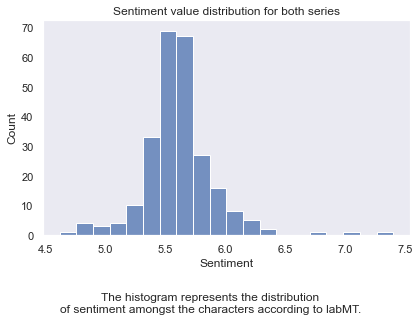

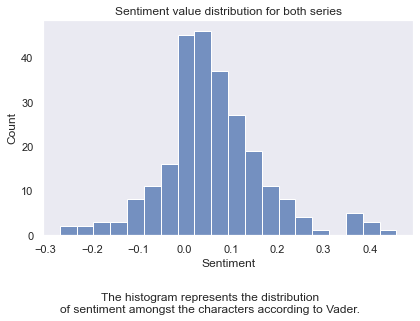

In [73]:
plot_sentiment_distribution(avatar_graph,'labMT','both')
plot_sentiment_distribution(avatar_graph,'Vader','both')

LabMT and Vader seem to portray the same picture, with something akin to a normal distribution. Although there seems to be a few outliers to the right in the Vader plot.

Vader puts most character in the *neutral* range around $0$, with less characters appearing at either end. At the right tail, there is an extraordinary amount of positive characters. It is possible that these are our main characters, who are figuratively shining beams of light. The number of negative characters is not especially high.

Overall, the results are not surprising, and are in line with what we would expect. ATLA is not known to especially positive or negative.


#### Top 10 character sentiment using LabMT

The previous plot gave us an overview, but hopefully we can get to the specifics here. At first we will consider the top 10 'happiest' characters according to LabMT.

Before we head into it, there is a small note. We initially tried to consider the top 10 and bottom 10 of *all* characters that have dialogue across both series. This causes the outliers present on the distribution above to appear. **However**, these characters are extremely uninteresting. It is characters with almost no dialogue or presence in the story (e.g.: *Merchant*, *Fire Nation Man*, *Guard Captain*). The little dialogue they have causes their sentiment to be heavily skewed. Therefore, in order to get more meaningful results, we will **drop** any characters that do not have more than **100 spoken words**.

In [74]:
sentiments_df = pd.DataFrame.from_dict(dict(avatar_graph.nodes(data=True)), orient='index')
#sentiments_df = sentiments_df.dropna(subset=['Vader_sentiment_atla','Vader_sentiment_lok','Vader_sentiment_both'])
#sentiments_df = sentiments_df.dropna(subset=['labMT_sentiment_atla','labMT_sentiment_lok','labMT_sentiment_both'])
# sentiments_df = sentiments_df.drop(columns=['word_count']) # Dropping as word_count here does not reflect dialogs
sentiments_df_dropped = sentiments_df.drop(columns=['labMT_sentiment_lok', 'labMT_sentiment_atla', 'Vader_sentiment_atla', 'Vader_sentiment_lok'])
sentiments_df_dropped = sentiments_df_dropped[sentiments_df_dropped.word_count > 100]

In [75]:
sentiments_df_dropped.sort_values(by='labMT_sentiment_both', ascending=False).head(10)

,nationality,gender,bending_art,community,community_name,word_count,labMT_sentiment_both,Vader_sentiment_both
Senna,Water Tribe,Female,Waterbender,1,Korra-Bolin-Mako,142.0,5.848803,0.089110
Ty Lee,Fire Nation,Female,Non-bender,0,Zuko-Iroh-Azula,299.0,5.843645,0.207650
Ikki,Air Nation,Female,Airbender,1,Korra-Bolin-Mako,562.0,5.835445,0.112534
Yin,Earth Kingdom,Female,Non-bender,1,Korra-Bolin-Mako,153.0,5.802484,0.161825
Pakku,Water Tribe,Male,Waterbender,3,Hakoda-Malina-Gilak,226.0,5.798982,0.167621
Jet,Earth Kingdom,Male,Non-bender,5,Aang-Katara-Sokka,203.0,5.795764,0.117753
Yue,Water Tribe,Female,Waterbender,0,Zuko-Iroh-Azula,242.0,5.790165,0.095820
Gun,Earth Kingdom,Male,Non-bender,1,Korra-Bolin-Mako,169.0,5.787692,0.147874
Joo Dee,Earth Kingdom,Female,Non-bender,5,Aang-Katara-Sokka,172.0,5.781279,0.103505
Zei,Earth Kingdom,Male,Non-bender,5,Aang-Katara-Sokka,203.0,5.777537,0.176929


#### Bottom 10 character sentiment using LabMT

In [76]:
sentiments_df_dropped.sort_values(by='labMT_sentiment_both', ascending=True).head(10)

,nationality,gender,bending_art,community,community_name,word_count,labMT_sentiment_both,Vader_sentiment_both
Saikhan,United Republic,Male,Earthbender,1,Korra-Bolin-Mako,107.0,5.308131,0.063132
Shyu,Fire Nation,Male,Firebender,0,Zuko-Iroh-Azula,150.0,5.329467,-0.015422
Raava,NaN,Female,Non-bender,1,Korra-Bolin-Mako,241.0,5.384730,-0.054711
Gan Jin leader,Earth Kingdom,Male,Non-bender,5,Aang-Katara-Sokka,143.0,5.387622,-0.083761
Zhang leader,Earth Kingdom,Female,Non-bender,5,Aang-Katara-Sokka,190.0,5.400263,-0.063002
Mechanist,Earth Kingdom,Male,Non-bender,5,Aang-Katara-Sokka,358.0,5.410726,-0.042000
Canyon guide,Earth Kingdom,Male,Earthbender,5,Aang-Katara-Sokka,115.0,5.416870,-0.024218
Chit Sang,Fire Nation,Male,Firebender,0,Zuko-Iroh-Azula,115.0,5.464870,0.063637
Two Toed Ping,United Republic,Male,Firebender,1,Korra-Bolin-Mako,101.0,5.464950,0.068352
Xin Fu,Earth Kingdom,Male,Earthbender,5,Aang-Katara-Sokka,119.0,5.470252,-0.012476


#### Top 10 character sentiment using Vader

In [77]:
sentiments_df_dropped.sort_values(by='Vader_sentiment_both', ascending=False).head(10)

,nationality,gender,bending_art,community,community_name,word_count,labMT_sentiment_both,Vader_sentiment_both
Ty Lee,Fire Nation,Female,Non-bender,0,Zuko-Iroh-Azula,299.0,5.843645,0.207650
Zei,Earth Kingdom,Male,Non-bender,5,Aang-Katara-Sokka,203.0,5.777537,0.176929
Pakku,Water Tribe,Male,Waterbender,3,Hakoda-Malina-Gilak,226.0,5.798982,0.167621
Yin,Earth Kingdom,Female,Non-bender,1,Korra-Bolin-Mako,153.0,5.802484,0.161825
Sozin,Fire Nation,Male,Firebender,0,Zuko-Iroh-Azula,212.0,5.767028,0.157504
Gun,Earth Kingdom,Male,Non-bender,1,Korra-Bolin-Mako,169.0,5.787692,0.147874
Hiroshi,Earth Kingdom,Male,Earthbender,4,Riley-Hiroshi-Visola,115.0,5.534000,0.146563
Teo,Earth Kingdom,Male,Non-bender,5,Aang-Katara-Sokka,174.0,5.700057,0.135319
Vaatu,NaN,Male,Non-bender,1,Korra-Bolin-Mako,160.0,5.598875,0.127987
Jet,Earth Kingdom,Male,Non-bender,5,Aang-Katara-Sokka,203.0,5.795764,0.117753


The most positive character, by a far margin, is *Ty Lee*. She is a young girl from the Fire Nation. The fandom wiki describes her as "*[...] bubbly and outgoing [...]*", which matches her sentiment value. Generally, her page describes her as affectionate and kind. 

There are also a few surprises here. *Vaatu* is the "*the spirit of darkness and chaos*" according the wiki. He is the main antagonist during *The Legend of Korra*, and can not exactly be described as a positive character. He even has dialogue where he speaks of annihilating other characters. However, we must he remember that he has little dialogue, only at 160 words. In some of this dialogue, he tricks another character, by appearing benevolent and kind, into freeing him from his prison. This could help explain why he is so high up. It is worth noting that Vaatu does not appear in the top 10 for LabMT.

*Sozin* is another case of confusion. He singlehandedly eradicated a large fraction of Air Nomads (not yet part of the Air Nation) in an attempt to gain power. He is also the person responsible for initiating the *Hundred-year war*, the main plot point of the first series. In short, he wishes the Fire Nation to reign supreme. We had to carefully examine his dialogue to account for this. It appears that he is only directly involved in very few scenes, where he is depicted in his (more positive) younger years. It is only other characters who speak of his atrocities.

We also find *none* of the main cast present in the top 10. This denies our hypothesis previously presented that the outliers could be main characters.

#### Bottom 10 character sentiment using Vader

In [78]:
sentiments_df_dropped.sort_values(by='Vader_sentiment_both', ascending=True).head(10)

,nationality,gender,bending_art,community,community_name,word_count,labMT_sentiment_both,Vader_sentiment_both
Gan Jin leader,Earth Kingdom,Male,Non-bender,5,Aang-Katara-Sokka,143.0,5.387622,-0.083761
Zhang leader,Earth Kingdom,Female,Non-bender,5,Aang-Katara-Sokka,190.0,5.400263,-0.063002
Raava,NaN,Female,Non-bender,1,Korra-Bolin-Mako,241.0,5.384730,-0.054711
Mechanist,Earth Kingdom,Male,Non-bender,5,Aang-Katara-Sokka,358.0,5.410726,-0.042000
Wan Shi Tong,NaN,Male,Non-bender,5,Aang-Katara-Sokka,210.0,5.586667,-0.028506
Canyon guide,Earth Kingdom,Male,Earthbender,5,Aang-Katara-Sokka,115.0,5.416870,-0.024218
Jeong Jeong,Fire Nation,Male,Firebender,0,Zuko-Iroh-Azula,244.0,5.513893,-0.016247
Shyu,Fire Nation,Male,Firebender,0,Zuko-Iroh-Azula,150.0,5.329467,-0.015422
Xin Fu,Earth Kingdom,Male,Earthbender,5,Aang-Katara-Sokka,119.0,5.470252,-0.012476
Mai,Fire Nation,Female,Non-bender,0,Zuko-Iroh-Azula,352.0,5.476222,-0.012045


*Raava* is the direct contrast to *Vaatu*. She is the spirit of light and peace, and one might find it equally surprising to find her present on the bottom 10. However, simply being the proctector of peace does not make her a positive character per default. The wiki describes her as abrasive and intolerant of people with differing beliefs. Therefore, we actually find this assessment to be accurate.

The rest of the list is not surprising. These are all characters that either have negative personalities, or have suffered deep personal losses. Nonetheless, most of these characters are from the first series, denoting a difference between the two.

#### Sentiment per community

In this section we will consider the sentiment of the previously found communities. This is calculated simply taking the mean of the individual community member's sentiment. Communities are named according to the three members with the highest degree.

In [79]:
sentiments_df_agg = sentiments_df.groupby('community_name').mean()
sentiments_df_agg = sentiments_df_agg.drop(['community'], axis=1)

##### Sentiment of communities according to LabMT

In [80]:
hap_lab = sentiments_df_agg.sort_values(by='labMT_sentiment_both', ascending=False)
hap_lab[['labMT_sentiment_both']]

,labMT_sentiment_both
community_name,
Kyoshi-Rangi-Jianzhu,5.744933
Zuko-Iroh-Azula,5.692851
Hakoda-Malina-Gilak,5.630671
Korra-Bolin-Mako,5.604507
Aang-Katara-Sokka,5.579210
Riley-Hiroshi-Visola,5.534000


##### Sentiment of communities according to Vader

In [81]:
hap_vad = sentiments_df_agg.sort_values(by='Vader_sentiment_both', ascending=False)
hap_vad[['Vader_sentiment_both']]

,Vader_sentiment_both
community_name,
Riley-Hiroshi-Visola,0.146563
Kyoshi-Rangi-Jianzhu,0.144424
Zuko-Iroh-Azula,0.064026
Aang-Katara-Sokka,0.058031
Korra-Bolin-Mako,0.055812
Hakoda-Malina-Gilak,0.035601


The top community is non-canon as mentioned before, so we will not consider it.

The Fire Nation community *Zuko-Iroh-Azula* surprises again by being relatively positive. Throughout this project, we confirm that the Fire Nation is not as negative as previously though, even beating out the *Aang-Katara-Sokka* community.

We also find the *Korra-Bolin-Mako* community, mainly associated with the second series, to be below most communities. This is consistent with our previous findings, indicating that *The Legend of Korra* could encompass a more negative mood.

#### Summary

We found the sentiment per character to be a normal distribution, with a slight overrepresentation of positive characters. We expected the overrepresentation to be main characters. This turned out to not be true.

The top 10 most positive and negative characters were in many cases surprising. Characters associated with negativity were in fact very positive and vice versa. We attribute this to the low number of dialogue for these characters, and that their actions are most often described by other characters. This is a downside of our approach. We did not find the main cast to be in either list.

By calculating the average sentiment of the previously found communities, we confirmed that the Fire Nation is not as bad as it seems.

*The Legend of Korra* continues to have a lower sentiment generally.



### Temporal sentiment analysis

The last section gave a more general overview of sentiment - we did not consider the temporal aspect present within a series. Now, we will use sentiment analysis to examine how the mood of episodes changes throughout both series. This will allow to compare episodes within series, but also give us an idea of how the second series differs from the first.

We have seen a few indications that *The Legend of Korra* could have a darker theme than *Avatar: The Last Airbender*. This is the central idea we wish to discover here.

We'll start at a low level of detail by examining the average sentiment across the two series. After that we will deepen our focus and look at sentiment per season and finally sentiment per episode.

#### Functions for calculating sentiment

In [82]:
def calculate_episode_labMT_sentiment(episodes_df):
    '''
    Calculating the sentiment for each episode
    Here the sentiment is calculated for every word in every sentence of the characters dialog and then we take the average
    '''


    sentiment_url = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'
    sentiment_values = pd.read_csv(sentiment_url, skiprows=3, delimiter='\t')[['word', 'happiness_average']]

    for index,row in episodes_df.iterrows():
        dialog = row['Dialog']
       
        text = ''
        for sentence in dialog:
            text = text + sentence + " "
        tokens = WordPunctTokenizer().tokenize(text) # Tokenize the text
        clean_text = [word for word in tokens if not word in stopwords.words() and word.isalpha() and len(word)>1] # Clean from stopwords and making sure that its not a special character
        clean_lemmas_text = [WordNetLemmatizer().lemmatize(token) for token in clean_text] # Lematize words
        final_clean_text = [word.lower() for word in clean_lemmas_text] # Remove capital letters


        text = FreqDist(final_clean_text)
#         print(text)
        sentiment = pd.DataFrame.from_dict(text, orient='index').reset_index()
        sentiment.columns = ['word', 'count']
        sentiment = sentiment.merge(sentiment_values, on=['word'])
        if sentiment.empty:
            continue
        sentiment['mean'] = (sentiment['happiness_average'] * sentiment['count']).sum() / \
                            sentiment['count'].sum()
        
        episodes_df.loc[index,'labMT_sentiment'] = sentiment['mean'].mean()

    return episodes_df


def calculate_episode_Vader_sentiment(episodes_df):
    '''
    Calculating the sentiment for each of episode 
    Here the sentiment is calculated for every sentence of the characters dialog and then we take the average
    '''

    analyzer = SentimentIntensityAnalyzer()

    for index,row in episodes_df.iterrows():
        
        dialog = row['Dialog']
        episode_sent = []
        for sentence in dialog:
            episode_sent.append(analyzer.polarity_scores(sentence)['compound'])
        
        avg_episode_sent = mean(episode_sent)
        episodes_df.loc[index,'Vader_sentiment'] = avg_episode_sent

    return episodes_df

In [83]:
dialog_df = pd.read_csv("atla_lok_transcript.csv",index_col=0)
dialog_df['dialogue'] = dialog_df['dialogue'].astype(str)
dialog_df

,series,episode_name,book,book_number,episode_number,character_name,dialogue
0,1.0,The Boy in the Iceberg,Water,1.0,1.0,Sokka,It's not getting away from me this time. Watch...
1,1.0,The Boy in the Iceberg,Water,1.0,1.0,Katara,"Sokka, look!"
2,1.0,The Boy in the Iceberg,Water,1.0,1.0,Katara,"But, Sokka! I caught one!"
3,1.0,The Boy in the Iceberg,Water,1.0,1.0,Katara,Hey!
4,1.0,The Boy in the Iceberg,Water,1.0,1.0,Sokka,Why is it that every time ''you'' play with ma...
...,...,...,...,...,...,...,...
16753,2.0,The Last Stand,Balance,4.0,113.0,Korra,"So, what now? Back to the dance floor?"
16754,2.0,The Last Stand,Balance,4.0,113.0,Asami,"I'm kind of all danced out. Honestly, after ev..."
16755,2.0,The Last Stand,Balance,4.0,113.0,Korra,"Let's do it! Let's go on a vacation, just the ..."
16756,2.0,The Last Stand,Balance,4.0,113.0,Asami,Really? Okay ... I've always wanted to see wha...


In [84]:
dialog_df_groups = dialog_df.groupby(['series','episode_name','book','book_number','episode_number'])['dialogue'].apply(lambda x: ','.join(x)).reset_index()
dialog_df_groups.rename(columns={"dialogue": "Dialog"},inplace=True)
dialog_df_groups.set_index("episode_name",inplace=True)


def split_into_list(text):
    text = str(text)
    return nltk.tokenize.sent_tokenize(text)


dialog_df_groups['Dialog'] = dialog_df_groups['Dialog'].apply(lambda x: split_into_list(x))
dialog_df_groups

,series,book,book_number,episode_number,Dialog
episode_name,,,,,
Appa's Lost Days,1.0,Earth,2.0,36.0,"[No!, Stop sinking!,Don't make me put this dow..."
Avatar Day,1.0,Earth,2.0,25.0,"[What are you doing in my mouth?, Momo, you ne..."
Bato of the Water Tribe,1.0,Water,1.0,15.0,"[Hey, look!, A sword made out of a whale's too..."
Bitter Work,1.0,Earth,2.0,29.0,"[Today's the day!, Can you believe it?, After ..."
City of Walls and Secrets,1.0,Earth,2.0,34.0,"[Look, the Inner Wall!, I can't believe we fin..."
...,...,...,...,...,...
The Voice in the Night,2.0,Air,1.0,65.0,"[Benders be on alert., After coming face to fa..."
Turning the Tides,2.0,Air,1.0,71.0,"[Amon's revolution grows stronger by the day.,..."
Venom of the Red Lotus,2.0,Change,3.0,100.0,"[The Red Lotus has captured the Avatar., Korra..."


In [85]:
dialog_df_groups = calculate_episode_labMT_sentiment(dialog_df_groups)
dialog_df_groups = calculate_episode_Vader_sentiment(dialog_df_groups)
dialog_df_groups

,series,book,book_number,episode_number,Dialog,labMT_sentiment,Vader_sentiment
episode_name,,,,,,,
Appa's Lost Days,1.0,Earth,2.0,36.0,"[No!, Stop sinking!,Don't make me put this dow...",5.464156,0.049345
Avatar Day,1.0,Earth,2.0,25.0,"[What are you doing in my mouth?, Momo, you ne...",5.573531,0.022081
Bato of the Water Tribe,1.0,Water,1.0,15.0,"[Hey, look!, A sword made out of a whale's too...",5.615349,0.078005
Bitter Work,1.0,Earth,2.0,29.0,"[Today's the day!, Can you believe it?, After ...",5.692702,0.142751
City of Walls and Secrets,1.0,Earth,2.0,34.0,"[Look, the Inner Wall!, I can't believe we fin...",5.603258,-0.001174
...,...,...,...,...,...,...,...
The Voice in the Night,2.0,Air,1.0,65.0,"[Benders be on alert., After coming face to fa...",5.610448,0.108320
Turning the Tides,2.0,Air,1.0,71.0,"[Amon's revolution grows stronger by the day.,...",5.626127,0.090068
Venom of the Red Lotus,2.0,Change,3.0,100.0,"[The Red Lotus has captured the Avatar., Korra...",5.621931,0.115671


With this, we have the sentiment of each episode for both series. We can use this information to extract temporal sentiment in the next sections.

#### Sentiment per series

We find the sentiment per series by grouping episodes by series and collecting the mean sentiment of each group.

In [86]:
series_sentiment = dialog_df_groups.groupby(['series']).mean()

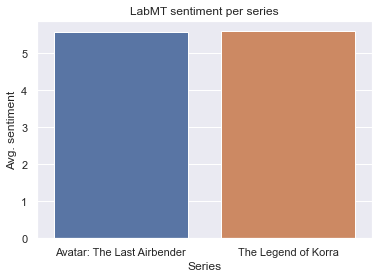

In [87]:
sns.barplot(x=['Avatar: The Last Airbender', 'The Legend of Korra'], y=series_sentiment['labMT_sentiment'])
plt.title('LabMT sentiment per series')
plt.xlabel('Series')
plt.ylabel('Avg. sentiment')
plt.show()

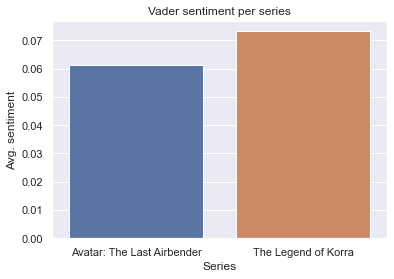

In [88]:
sns.barplot(x=['Avatar: The Last Airbender', 'The Legend of Korra'], y=series_sentiment['Vader_sentiment'])
plt.title('Vader sentiment per series')
plt.xlabel('Series')
plt.ylabel('Avg. sentiment')
plt.show()

To our surprise, it appears that *The Legend of Korra* is actually more positive than *Avatar: The Last Airbender* according to Vader. This is opposite from what we had gathered based on small pieces of information so far. This reinforces the idea that you should always confirm your hypothesis instead of assuming it to be true.

With this level of detail it is hard to explain *why* this is the case. Next, we'll look at the sentiment per season.

#### Sentiment per season

In [89]:
# number books from 1 ... 7.
dialog_df_groups['book_number_cumul'] = 3 * (dialog_df_groups.series - 1) + dialog_df_groups.book_number
season_sentiment = dialog_df_groups.groupby('book_number_cumul').mean()

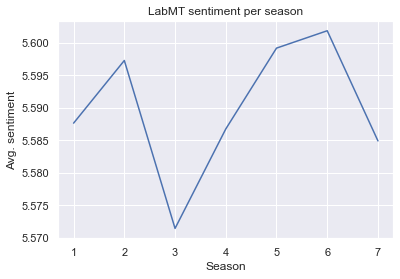

In [90]:
sns.lineplot(x=season_sentiment.index, y=season_sentiment['labMT_sentiment'])
plt.title('LabMT sentiment per season')
plt.xlabel('Season')
plt.ylabel('Avg. sentiment')
plt.show()

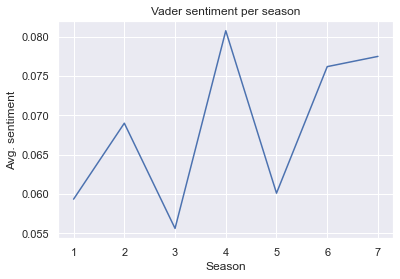

In [91]:
sns.lineplot(x=season_sentiment.index, y=season_sentiment['Vader_sentiment'])
plt.title('Vader sentiment per season')
plt.xlabel('Season')
plt.ylabel('Avg. sentiment')
plt.show()

According to Vader, it is clear the the sentiment of series 1 is lower than series 2. Series 1 ends at a low point at season 3, before jumping up at the start of *The Legend of Korra* in season 4. It is an interesting tactic to start at a high note at season 4, before dropping down quickly in season 5. The sentiment then builds up the last two seasons, ending the overall story on a high note. 

One might be surprised that the first series ends at a low point. The finale of *Avatar: The Last Airbender* marks the end of the *Hundred-year war*. Ending a war and bringing peace is of course a positive thing - but we never get to the fruits of their labor in the first series. It ends quite abruptly after the climax, leaving no time to rebuild the world which has been plagued by war for so long. Not before the start of *The Legend of Korra*, which is set 70 years after the end of *Avatar: The Last Airbender*. This also explains the high sentiment in season 4, which is the first book of *The Legend of Korra*.

#### Sentiment per episode

Sentiment per episode is the highest level of temporal detail that we can get. This means that we longer have to average sentiment values. We can just use the values as is.

In [92]:
episode_sentiment = dialog_df_groups.groupby('episode_number').mean()

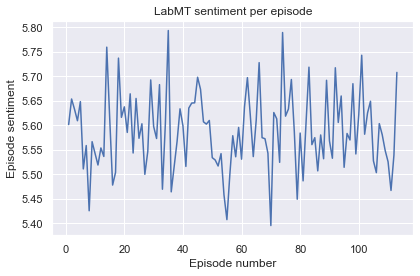

In [93]:
sns.lineplot(x=episode_sentiment.index, y=episode_sentiment['labMT_sentiment'])
plt.title('LabMT sentiment per episode')
plt.xlabel('Episode number')
plt.ylabel('Episode sentiment')

plt.tight_layout()
plt.show()

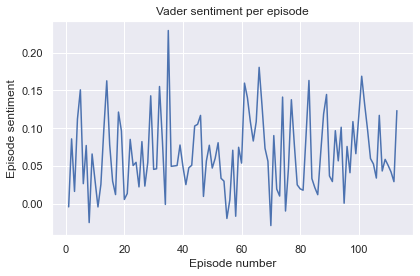

In [94]:
sns.lineplot(x=episode_sentiment.index, y=episode_sentiment['Vader_sentiment'])
plt.title('Vader sentiment per episode')
plt.xlabel('Episode number')
plt.ylabel('Episode sentiment')

plt.tight_layout()
plt.show()

It feels like this level of detail is too great. Both the LabMT and Vader line plots look "squiggly" due to large oscillations in sentiment values. For reference, *The Legend of Korra* begins at episode number 62. 

There seems to be a great deal of back and forth within both series. This could indicate mini-conflicts that appear, only to be resolved in the next few episodes. There are few sub-curves with slow growth. Most values change very quickly. One thing is for certain however: *The Legend of Korra* (and the two series as a whole) end on a large high note, opposite to the original series.

#### Summary

Sentiment per series showed the first series is more negative than the sequel series. This is contrary to what we had been led to believe up til this point.

Sentiment per season showed the dramatic structure of both series. *Avatar: The Last Airbender* ends on a low note while still resolving the main conflict adequately, thereby setting up *The Legend of Korra* to start on a high note. The sequel series also ends on a positive note.

Sentiment per episode gave too much detail - sentiment values had too great oscillations that caused the plot to look "squiggly", i.e. trends are hard to discern.

## Discussion

We consider the extraction of data from the fandom wiki to be a success in general. Extracting character pages went smoothly, since it contains few redirects and disambiguations. Furthermore, we managed to retrieve almost 600 characters, which we consider a success. We were initially afraid that the ATLA universe might contain too few characters, or if the GCC would be too small. The extraction of character dialogue was also successful, but required more work than expected. There were a few hiccups, mostly due to the naming conventing used on the wiki when attributing dialogue to characters. This caused a small amount of dialogue (less than 1%) to get lost, since we could not match the character name easily.

We do not find the word clouds particularly successful. They rarely gave distinct keywords that could accurately describe a nationality. We discussed focusing on adverbs and adjectives instead of all words to hone in on important terms. We also had a small bug when removing character names from our corpus, that caused some words to be falsely truncated.

Community detection with the Louvain method was a success. Upon further examination, all of the community members made a lot of sense, and each could clearly be seen when visualized. 

Sentiment analysis was interesting. The top and bottom characters were unexpected, but in the end made sense for most characters. It is a shame that our approach gets so easily skewed by characters with little dialogue. We ended up dropping all characters will less than 100 words spoken, but even that felt on the low side. Increasing it any further was not an option however, since that quickly eliminated almost all characters. 

Temporal sentiment analysis ended up proving our hypothesis that the second series is darker than the sequel series wrong. It was interesting to see how the dramatic structures of the series differed, with *Avatar: The Last Airbender* ending on a low note while the opposite was true for *The Legend of Korra*. The sentiment per episode did not work well - it was too difficult to notice trends in the graph. A line plot is certainly not the best tool for visualizing this property.

In this notebook, we focus on the animated series, which is based on a series of graphic novels. The graphic novels are *also* transcribed on the fandom wiki. It would have been interesting to compare the animated series and the graphic novels. Sadly, the group could not find the time for this, as it would have been a large undertaking.

## Contributions

- Setting up website: Stefanos
- Extracting character pages: Stefanos
- Extracting character dialogue: Philip
- Basic stats: Philip
- Word clouds and nationalities: Nikiforos
- Communities: Nikiforos
- Sentiment analysis (per character, top 10, bottom 10): Nikiforos
- Sentiment analysis (per community): Stefanos
- Temporal sentiment analaysis: Philip